In [1]:
import torch.nn as nn
import torch
from torch import autograd
from torchvision import transforms as tfs

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import math

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
#把常用的2个卷积操作简单封装下
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), #添加了BN层
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Unet, self).__init__()
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        # self.conv4 = DoubleConv(256, 512)
        # self.pool4 = nn.MaxPool2d(2)
        # self.conv5 = DoubleConv(512, 1024)

        # 逆卷积，也可以使用上采样
        # self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        # self.conv6 = DoubleConv(1024, 512)
        # self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        # self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        # p3 = self.pool3(c3)
        # c4 = self.conv4(p3)
        # p4 = self.pool4(c4)
        # c5 = self.conv5(p4)

        # up_6 = self.up6(c5)
        # merge6 = torch.cat([up_6, c4], dim=1)
        # c6 = self.conv6(merge6)

        # up_7 = self.up7(c6)
        # merge7 = torch.cat([up_7, c3], dim=1)
        # c7 = self.conv7(merge7)

        up_8 = self.up8(c3)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)

        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)

        c10 = self.conv10(c9)
        out = nn.Sigmoid()(c10)
        return out

In [3]:
class trainData():
    def __init__(self):
        ''' 图像数据与标记数据路径 s1: 各为 150张 '''
        self.image_dir = './imgData/train_data/s1/image/'
        self.label_dir = './imgData/train_data/s1/label/'
        self.image_data = None
        self.label_data = None
        
    def get_image_file(self):
        ''' 图像数据为 512 * 512, 为源数据值, 未作改动(范围在: -500左右 ~ 1000+ ) '''
        file_dir = self.image_dir
        image_data = []

        files = os.listdir(file_dir)
        files.sort(key= lambda x:int(x[:-4]))
        for file in files:
            if os.path.splitext(file)[1] == '.npy':
                img_item = np.load(file_dir + file)
                image_data.append(img_item)
        self.image_data = image_data
        return image_data
    
    def im_handle(self, image, min=0.0, max=255.0):
        image[image < min] = min
        image[image > max] = max
        image = image / max
        return image

    def get_label_file(self):
        ''' 标签数据为 512 * 512, 为0/1 '''
        file_dir = self.label_dir
        label_data = []

        files = os.listdir(file_dir)
        files.sort(key= lambda x:int(x[:-4]))
        for file in files:
            if os.path.splitext(file)[1] == '.npy':
                img_item = np.load(file_dir + file)
                label_data.append(img_item)
        self.label_data = label_data
        return label_data
    
    def test_show(self):
        ''' 随机取九张展示 '''
        if self.image_data == None or self.label_data == None:
            self.get_image_file()
            self.get_label_file()
        
        _, figs = plt.subplots(3, 3)
        for i in range(3):
            for j in range(3): 
                index = random.randint(0,len(self.image_data)-1)
                img_item = self.image_data[index]
                label_item = self.label_data[index]
                # 标签处简单处理，显示浅红色
                img_item[img_item < 0] = 0
                img_item[img_item > 255] = 255
                img_item = img_item.astype(np.uint8)
                img_item = cv2.merge([img_item, img_item, img_item])
                img_item[label_item > 0] = img_item[label_item > 0] * 0.6 + (80, 0, 0)

                figs[i][j].imshow(img_item)
        plt.show()
    
    def get_train_data(self,number=50,batch_size=5,channel=1,im_size=(512,512)):
        ''' 
        先试试使用未经处理的图像数据
        注意：channel只能为奇数
        '''
        self.get_image_file()
        self.get_label_file()

        self.batch_size = 5
        self.channel = channel
        
        # 此时数据范围较大, 对某范围内数值进行压缩处理, 其余直接取极值
        l_temp = []
        for i in self.image_data:
            i = self.im_handle(i, 0.0, 300.0)
            l_temp.append(i)
        self.image_data = l_temp

        train_data = []
        train_label = []
        while len(train_data) < number: 
            l1 = []
            l2 = []
            for i in range(batch_size):
                # 随机从图片序列中选一个channel起始索引
                ind = random.randint(0, len(self.image_data) - channel)
                # channel压缩
                temp = self.image_data[ind]
                # temp = temp[:,:,np.newaxis,np.newaxis]
                temp = temp[np.newaxis,np.newaxis,:,:]
                for i in range(ind + 1, ind + channel):
                    temp1 = self.image_data[i][np.newaxis, np.newaxis, :, :]
                    # torch.cat([temp, temp1], dim=1)
                    temp = np.concatenate((temp, temp1), axis=1)
                l1.append(temp)

                # label只能是三维，channel只能为奇数
                temp = self.label_data[int((ind*2+channel-1)/2)]
                temp = temp[np.newaxis,:,:]
                l2.append(temp)
            
            t1 = l1[0]
            t2 = l2[0]
            for i in range(1,batch_size):
                # torch.cat([t1, l1[i]], dim=3)
                # torch.cat([t2, l2[i]], dim=3)
                t1 = np.concatenate((t1, l1[i]), axis=0)
                t2 = np.concatenate((t2, l2[i]), axis=0)
            # 将numpy转化为torch.tensor
            t1 = torch.from_numpy(t1)
            t1 = torch.tensor(t1, dtype=torch.float32)
            t2 = torch.from_numpy(t2)
            t2 = torch.tensor(t2, dtype=torch.float32)

            # 默认大小为(512,512)的不处理
            if im_size != (512, 512):
                ind_x = round(random.random() * (512 - im_size[0]))
                ind_y = round(random.random() * (512 - im_size[1]))
                ind_xx = torch.LongTensor(list(range(ind_x, ind_x + im_size[0])))
                ind_yy = torch.LongTensor(list(range(ind_y, ind_y + im_size[1])))
                t1 = torch.index_select(t1, 2, ind_xx)
                t1 = torch.index_select(t1, 3, ind_yy)

                t2 = torch.index_select(t2, 1, ind_xx)
                t2 = torch.index_select(t2, 2, ind_yy)
            
            train_data.append(t1)
            train_label.append(t2)
        
        return train_data,train_label
        # return self.image_data, self.label_data

class Divide:
    def __init__(self, b_w, b_h):
        '''
        b_w: block width
        b_h: block height
        '''
        self.block_width = b_w
        self.block_height = b_h

    def encode(self, mat):
        (W, H) = mat.shape
        # (192, 168)->(24,21)
        w_len = int(W / self.block_width)
        h_len = int(H / self.block_height)
        res = np.zeros((self.block_width * self.block_height, w_len * h_len))
        for i in range(h_len):
            for j in range(w_len):
                temp = mat[j * self.block_width:(j + 1) * self.block_width,
                           i * self.block_height:(i + 1) * self.block_height]
                temp = temp.reshape(self.block_width * self.block_height)
                res[:, i * w_len + j] = temp
        return res

    def decode(self, mat, W, H):
        '''
        mat.shape should be ( block_width*block_height, ~ = 24*21 )
        '''
        w_len = int(W / self.block_width)
        h_len = int(H / self.block_height)
        mat = mat.reshape(self.block_width * self.block_height, w_len * h_len)
        
        res = np.zeros((W, H))
        for i in range(h_len):
            for j in range(w_len):
                temp = mat[:, i * w_len + j]
                temp = temp.reshape(self.block_width, self.block_height)
                res[j * self.block_width:(j + 1) * self.block_width,
                    i * self.block_height:(i + 1) * self.block_height] = temp
        return res

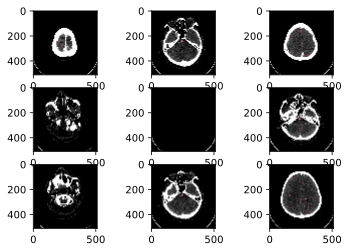

D:\softwar\academic\anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\softwar\academic\anaconda3\lib\site-packages\ipykernel_launcher.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  

Epoch:0 step:173 loss: 0.693146
Epoch:0 step:174 loss: 0.693146
Epoch:0 step:175 loss: 0.693146
Epoch:0 step:176 loss: 0.693146
Epoch:0 step:177 loss: 0.693146
Epoch:0 step:178 loss: 0.693146
Epoch:0 step:179 loss: 0.693146
Epoch:0 step:180 loss: 0.693146
Epoch:0 step:181 loss: 0.693146
Epoch:0 step:182 loss: 0.693146
Epoch:0 step:183 loss: 0.693146
Epoch:0 step:184 loss: 0.693146
Epoch:0 step:185 loss: 0.693146
Epoch:0 step:186 loss: 0.693146
Epoch:0 step:187 loss: 0.693146
Epoch:0 step:188 loss: 0.693146
Epoch:0 step:189 loss: 0.693146
Epoch:0 step:190 loss: 0.693146
Epoch:0 step:191 loss: 0.693146
Epoch:0 step:192 loss: 0.693146
Epoch:0 step:193 loss: 0.693146
Epoch:0 step:194 loss: 0.693146
Epoch:0 step:195 loss: 0.693146
Epoch:0 step:196 loss: 0.693146
Epoch:0 step:197 loss: 0.693146
Epoch:0 step:198 loss: 0.693146
Epoch:0 step:199 loss: 0.693146
Epoch:0 step:200 loss: 0.693146
Epoch:0 step:201 loss: 0.693146
Epoch:0 step:202 loss: 0.693146
Epoch:0 step:203 loss: 0.693146
Epoch:0 

Epoch:0 step:429 loss: 0.693146
Epoch:0 step:430 loss: 0.693146
Epoch:0 step:431 loss: 0.693146
Epoch:0 step:432 loss: 0.693146
Epoch:0 step:433 loss: 0.693146
Epoch:0 step:434 loss: 0.693146
Epoch:0 step:435 loss: 0.693146
Epoch:0 step:436 loss: 0.693146
Epoch:0 step:437 loss: 0.693146
Epoch:0 step:438 loss: 0.693146
Epoch:0 step:439 loss: 0.693146
Epoch:0 step:440 loss: 0.693146
Epoch:0 step:441 loss: 0.693146
Epoch:0 step:442 loss: 0.693146
Epoch:0 step:443 loss: 0.693146
Epoch:0 step:444 loss: 0.693146
Epoch:0 step:445 loss: 0.693146
Epoch:0 step:446 loss: 0.693146
Epoch:0 step:447 loss: 0.693146
Epoch:0 step:448 loss: 0.693146
Epoch:0 step:449 loss: 0.693146
Epoch:0 step:450 loss: 0.693146
Epoch:0 step:451 loss: 0.693146
Epoch:0 step:452 loss: 0.693146
Epoch:0 step:453 loss: 0.693146
Epoch:0 step:454 loss: 0.693146
Epoch:0 step:455 loss: 0.693146
Epoch:0 step:456 loss: 0.693146
Epoch:0 step:457 loss: 0.693146
Epoch:0 step:458 loss: 0.693146
Epoch:0 step:459 loss: 0.693146
Epoch:0 

Epoch:0 step:685 loss: 0.693146
Epoch:0 step:686 loss: 0.693146
Epoch:0 step:687 loss: 0.693146
Epoch:0 step:688 loss: 0.693146
Epoch:0 step:689 loss: 0.693146
Epoch:0 step:690 loss: 0.693146
Epoch:0 step:691 loss: 0.693146
Epoch:0 step:692 loss: 0.693146
Epoch:0 step:693 loss: 0.693146
Epoch:0 step:694 loss: 0.693146
Epoch:0 step:695 loss: 0.693146
Epoch:0 step:696 loss: 0.693146
Epoch:0 step:697 loss: 0.693146
Epoch:0 step:698 loss: 0.693146
Epoch:0 step:699 loss: 0.693146
Epoch:0 step:700 loss: 0.693146
Epoch:0 step:701 loss: 0.693146
Epoch:0 step:702 loss: 0.693146
Epoch:0 step:703 loss: 0.693146
Epoch:0 step:704 loss: 0.693146
Epoch:0 step:705 loss: 0.693146
Epoch:0 step:706 loss: 0.693146
Epoch:0 step:707 loss: 0.693146
Epoch:0 step:708 loss: 0.693146
Epoch:0 step:709 loss: 0.693146
Epoch:0 step:710 loss: 0.693146
Epoch:0 step:711 loss: 0.693146
Epoch:0 step:712 loss: 0.693146
Epoch:0 step:713 loss: 0.693146
Epoch:0 step:714 loss: 0.693146
Epoch:0 step:715 loss: 0.693146
Epoch:0 

Test Epoch:0 step:60 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:61 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:62 loss: 0.693146tensor(6.4964e-10, grad_fn=<DivBackward0>)
Test Epoch:0 step:63 loss: 0.693146tensor(1.1165e-09, grad_fn=<DivBackward0>)
Test Epoch:0 step:64 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:65 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:66 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:67 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:68 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:69 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:70 loss: 0.693146tensor(6.5745e-09, grad_fn=<DivBackward0>)
Test Epoch:0 step:71 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:72 loss: 0.693146tensor(8.5010e-10, grad_fn=<DivBackward0>)
Test Epoch:0 step:73 loss: 0.693146tensor(0., grad_fn=<Div

Test Epoch:0 step:169 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:170 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:171 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:172 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:173 loss: 0.693146tensor(1.2006e-11, grad_fn=<DivBackward0>)
Test Epoch:0 step:174 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:175 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:176 loss: 0.693146tensor(5.4527e-09, grad_fn=<DivBackward0>)
Test Epoch:0 step:177 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:178 loss: 0.693146tensor(4.6358e-10, grad_fn=<DivBackward0>)
Test Epoch:0 step:179 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:180 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:0 step:181 loss: 0.693146tensor(2.9978e-09, grad_fn=<DivBackward0>)
Test Epoch:0 step:182 loss: 0.693146tensor(0.

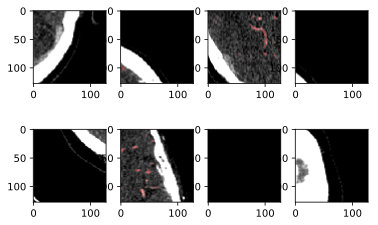

Epoch:1 step:0 loss: 0.693146
Epoch:1 step:1 loss: 0.693146
Epoch:1 step:2 loss: 0.693146
Epoch:1 step:3 loss: 0.693146
Epoch:1 step:4 loss: 0.693146
Epoch:1 step:5 loss: 0.693146
Epoch:1 step:6 loss: 0.693146
Epoch:1 step:7 loss: 0.693146
Epoch:1 step:8 loss: 0.693146
Epoch:1 step:9 loss: 0.693146
Epoch:1 step:10 loss: 0.693146
Epoch:1 step:11 loss: 0.693146
Epoch:1 step:12 loss: 0.693146
Epoch:1 step:13 loss: 0.693146
Epoch:1 step:14 loss: 0.693146
Epoch:1 step:15 loss: 0.693146
Epoch:1 step:16 loss: 0.693146
Epoch:1 step:17 loss: 0.693146
Epoch:1 step:18 loss: 0.693146
Epoch:1 step:19 loss: 0.693146
Epoch:1 step:20 loss: 0.693146
Epoch:1 step:21 loss: 0.693146
Epoch:1 step:22 loss: 0.693146
Epoch:1 step:23 loss: 0.693146
Epoch:1 step:24 loss: 0.693146
Epoch:1 step:25 loss: 0.693146
Epoch:1 step:26 loss: 0.693146
Epoch:1 step:27 loss: 0.693146
Epoch:1 step:28 loss: 0.693146
Epoch:1 step:29 loss: 0.693146
Epoch:1 step:30 loss: 0.693146
Epoch:1 step:31 loss: 0.693146
Epoch:1 step:32 lo

Epoch:1 step:259 loss: 0.693146
Epoch:1 step:260 loss: 0.693146
Epoch:1 step:261 loss: 0.693146
Epoch:1 step:262 loss: 0.693146
Epoch:1 step:263 loss: 0.693146
Epoch:1 step:264 loss: 0.693146
Epoch:1 step:265 loss: 0.693146
Epoch:1 step:266 loss: 0.693146
Epoch:1 step:267 loss: 0.693146
Epoch:1 step:268 loss: 0.693146
Epoch:1 step:269 loss: 0.693146
Epoch:1 step:270 loss: 0.693146
Epoch:1 step:271 loss: 0.693146
Epoch:1 step:272 loss: 0.693146
Epoch:1 step:273 loss: 0.693146
Epoch:1 step:274 loss: 0.693146
Epoch:1 step:275 loss: 0.693146
Epoch:1 step:276 loss: 0.693146
Epoch:1 step:277 loss: 0.693146
Epoch:1 step:278 loss: 0.693146
Epoch:1 step:279 loss: 0.693146
Epoch:1 step:280 loss: 0.693146
Epoch:1 step:281 loss: 0.693146
Epoch:1 step:282 loss: 0.693146
Epoch:1 step:283 loss: 0.693146
Epoch:1 step:284 loss: 0.693146
Epoch:1 step:285 loss: 0.693146
Epoch:1 step:286 loss: 0.693146
Epoch:1 step:287 loss: 0.693146
Epoch:1 step:288 loss: 0.693146
Epoch:1 step:289 loss: 0.693146
Epoch:1 

Epoch:1 step:515 loss: 0.693146
Epoch:1 step:516 loss: 0.693146
Epoch:1 step:517 loss: 0.693146
Epoch:1 step:518 loss: 0.693146
Epoch:1 step:519 loss: 0.693146
Epoch:1 step:520 loss: 0.693146
Epoch:1 step:521 loss: 0.693146
Epoch:1 step:522 loss: 0.693146
Epoch:1 step:523 loss: 0.693146
Epoch:1 step:524 loss: 0.693146
Epoch:1 step:525 loss: 0.693146
Epoch:1 step:526 loss: 0.693146
Epoch:1 step:527 loss: 0.693146
Epoch:1 step:528 loss: 0.693146
Epoch:1 step:529 loss: 0.693146
Epoch:1 step:530 loss: 0.693146
Epoch:1 step:531 loss: 0.693146
Epoch:1 step:532 loss: 0.693146
Epoch:1 step:533 loss: 0.693146
Epoch:1 step:534 loss: 0.693146
Epoch:1 step:535 loss: 0.693146
Epoch:1 step:536 loss: 0.693146
Epoch:1 step:537 loss: 0.693146
Epoch:1 step:538 loss: 0.693146
Epoch:1 step:539 loss: 0.693146
Epoch:1 step:540 loss: 0.693146
Epoch:1 step:541 loss: 0.693146
Epoch:1 step:542 loss: 0.693146
Epoch:1 step:543 loss: 0.693146
Epoch:1 step:544 loss: 0.693146
Epoch:1 step:545 loss: 0.693146
Epoch:1 

Epoch:1 step:771 loss: 0.693146
Epoch:1 step:772 loss: 0.693146
Epoch:1 step:773 loss: 0.693146
Epoch:1 step:774 loss: 0.693146
Epoch:1 step:775 loss: 0.693146
Epoch:1 step:776 loss: 0.693146
Epoch:1 step:777 loss: 0.693146
Epoch:1 step:778 loss: 0.693146
Epoch:1 step:779 loss: 0.693146
Epoch:1 step:780 loss: 0.693146
Epoch:1 step:781 loss: 0.693146
Epoch:1 step:782 loss: 0.693146
Epoch:1 step:783 loss: 0.693146
Epoch:1 step:784 loss: 0.693146
Epoch:1 step:785 loss: 0.693146
Epoch:1 step:786 loss: 0.693146
Epoch:1 step:787 loss: 0.693146
Epoch:1 step:788 loss: 0.693146
Epoch:1 step:789 loss: 0.693146
Epoch:1 step:790 loss: 0.693146
Epoch:1 step:791 loss: 0.693146
Epoch:1 step:792 loss: 0.693146
Epoch:1 step:793 loss: 0.693146
Epoch:1 step:794 loss: 0.693146
Epoch:1 step:795 loss: 0.693146
Epoch:1 step:796 loss: 0.693146
Epoch:1 step:797 loss: 0.693146
Epoch:1 step:798 loss: 0.693146
Epoch:1 step:799 loss: 0.693146
Test Epoch:1 step:0 loss: 0.693146tensor(1.3604e-09, grad_fn=<DivBackwar

Test Epoch:1 step:97 loss: 0.693146tensor(3.1644e-13, grad_fn=<DivBackward0>)
Test Epoch:1 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:1 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:1 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:1 step:101 loss: 0.693146tensor(7.1235e-10, grad_fn=<DivBackward0>)
Test Epoch:1 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:1 step:103 loss: 0.693146tensor(3.2490e-10, grad_fn=<DivBackward0>)
Test Epoch:1 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:1 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:1 step:106 loss: 0.693146tensor(8.0307e-10, grad_fn=<DivBackward0>)
Test Epoch:1 step:107 loss: 0.693146tensor(1.3955e-09, grad_fn=<DivBackward0>)
Test Epoch:1 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:1 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:1 step:110 loss: 0.693146tens

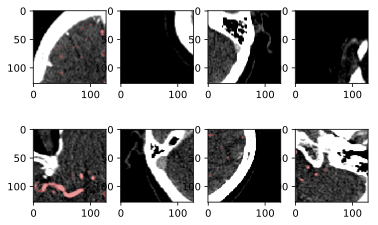

Epoch:2 step:0 loss: 0.693146
Epoch:2 step:1 loss: 0.693146
Epoch:2 step:2 loss: 0.693146
Epoch:2 step:3 loss: 0.693146
Epoch:2 step:4 loss: 0.693146
Epoch:2 step:5 loss: 0.693146
Epoch:2 step:6 loss: 0.693146
Epoch:2 step:7 loss: 0.693146
Epoch:2 step:8 loss: 0.693146
Epoch:2 step:9 loss: 0.693146
Epoch:2 step:10 loss: 0.693146
Epoch:2 step:11 loss: 0.693146
Epoch:2 step:12 loss: 0.693146
Epoch:2 step:13 loss: 0.693146
Epoch:2 step:14 loss: 0.693146
Epoch:2 step:15 loss: 0.693146
Epoch:2 step:16 loss: 0.693146
Epoch:2 step:17 loss: 0.693146
Epoch:2 step:18 loss: 0.693146
Epoch:2 step:19 loss: 0.693146
Epoch:2 step:20 loss: 0.693146
Epoch:2 step:21 loss: 0.693146
Epoch:2 step:22 loss: 0.693146
Epoch:2 step:23 loss: 0.693146
Epoch:2 step:24 loss: 0.693146
Epoch:2 step:25 loss: 0.693146
Epoch:2 step:26 loss: 0.693146
Epoch:2 step:27 loss: 0.693146
Epoch:2 step:28 loss: 0.693146
Epoch:2 step:29 loss: 0.693146
Epoch:2 step:30 loss: 0.693146
Epoch:2 step:31 loss: 0.693146
Epoch:2 step:32 lo

Epoch:2 step:259 loss: 0.693146
Epoch:2 step:260 loss: 0.693146
Epoch:2 step:261 loss: 0.693146
Epoch:2 step:262 loss: 0.693146
Epoch:2 step:263 loss: 0.693146
Epoch:2 step:264 loss: 0.693146
Epoch:2 step:265 loss: 0.693146
Epoch:2 step:266 loss: 0.693146
Epoch:2 step:267 loss: 0.693146
Epoch:2 step:268 loss: 0.693146
Epoch:2 step:269 loss: 0.693146
Epoch:2 step:270 loss: 0.693146
Epoch:2 step:271 loss: 0.693146
Epoch:2 step:272 loss: 0.693146
Epoch:2 step:273 loss: 0.693146
Epoch:2 step:274 loss: 0.693146
Epoch:2 step:275 loss: 0.693146
Epoch:2 step:276 loss: 0.693146
Epoch:2 step:277 loss: 0.693146
Epoch:2 step:278 loss: 0.693146
Epoch:2 step:279 loss: 0.693146
Epoch:2 step:280 loss: 0.693146
Epoch:2 step:281 loss: 0.693146
Epoch:2 step:282 loss: 0.693146
Epoch:2 step:283 loss: 0.693146
Epoch:2 step:284 loss: 0.693146
Epoch:2 step:285 loss: 0.693146
Epoch:2 step:286 loss: 0.693146
Epoch:2 step:287 loss: 0.693146
Epoch:2 step:288 loss: 0.693146
Epoch:2 step:289 loss: 0.693146
Epoch:2 

Epoch:2 step:515 loss: 0.693146
Epoch:2 step:516 loss: 0.693146
Epoch:2 step:517 loss: 0.693146
Epoch:2 step:518 loss: 0.693146
Epoch:2 step:519 loss: 0.693146
Epoch:2 step:520 loss: 0.693146
Epoch:2 step:521 loss: 0.693146
Epoch:2 step:522 loss: 0.693146
Epoch:2 step:523 loss: 0.693146
Epoch:2 step:524 loss: 0.693146
Epoch:2 step:525 loss: 0.693146
Epoch:2 step:526 loss: 0.693146
Epoch:2 step:527 loss: 0.693146
Epoch:2 step:528 loss: 0.693146
Epoch:2 step:529 loss: 0.693146
Epoch:2 step:530 loss: 0.693146
Epoch:2 step:531 loss: 0.693146
Epoch:2 step:532 loss: 0.693146
Epoch:2 step:533 loss: 0.693146
Epoch:2 step:534 loss: 0.693146
Epoch:2 step:535 loss: 0.693146
Epoch:2 step:536 loss: 0.693146
Epoch:2 step:537 loss: 0.693146
Epoch:2 step:538 loss: 0.693146
Epoch:2 step:539 loss: 0.693146
Epoch:2 step:540 loss: 0.693146
Epoch:2 step:541 loss: 0.693146
Epoch:2 step:542 loss: 0.693146
Epoch:2 step:543 loss: 0.693146
Epoch:2 step:544 loss: 0.693146
Epoch:2 step:545 loss: 0.693146
Epoch:2 

Epoch:2 step:771 loss: 0.693146
Epoch:2 step:772 loss: 0.693146
Epoch:2 step:773 loss: 0.693146
Epoch:2 step:774 loss: 0.693146
Epoch:2 step:775 loss: 0.693146
Epoch:2 step:776 loss: 0.693146
Epoch:2 step:777 loss: 0.693146
Epoch:2 step:778 loss: 0.693146
Epoch:2 step:779 loss: 0.693146
Epoch:2 step:780 loss: 0.693146
Epoch:2 step:781 loss: 0.693146
Epoch:2 step:782 loss: 0.693146
Epoch:2 step:783 loss: 0.693146
Epoch:2 step:784 loss: 0.693146
Epoch:2 step:785 loss: 0.693146
Epoch:2 step:786 loss: 0.693146
Epoch:2 step:787 loss: 0.693146
Epoch:2 step:788 loss: 0.693146
Epoch:2 step:789 loss: 0.693146
Epoch:2 step:790 loss: 0.693146
Epoch:2 step:791 loss: 0.693146
Epoch:2 step:792 loss: 0.693146
Epoch:2 step:793 loss: 0.693146
Epoch:2 step:794 loss: 0.693146
Epoch:2 step:795 loss: 0.693146
Epoch:2 step:796 loss: 0.693146
Epoch:2 step:797 loss: 0.693146
Epoch:2 step:798 loss: 0.693146
Epoch:2 step:799 loss: 0.693146
Test Epoch:2 step:0 loss: 0.693146tensor(1.4004e-09, grad_fn=<DivBackwar

Test Epoch:2 step:97 loss: 0.693146tensor(3.3380e-13, grad_fn=<DivBackward0>)
Test Epoch:2 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:2 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:2 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:2 step:101 loss: 0.693146tensor(7.0020e-10, grad_fn=<DivBackward0>)
Test Epoch:2 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:2 step:103 loss: 0.693146tensor(3.3961e-10, grad_fn=<DivBackward0>)
Test Epoch:2 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:2 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:2 step:106 loss: 0.693146tensor(8.1686e-10, grad_fn=<DivBackward0>)
Test Epoch:2 step:107 loss: 0.693146tensor(1.2624e-09, grad_fn=<DivBackward0>)
Test Epoch:2 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:2 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:2 step:110 loss: 0.693146tens

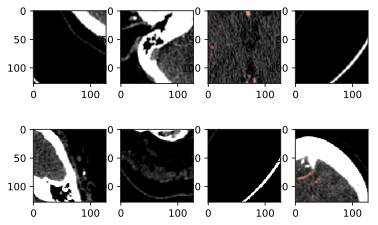

Epoch:3 step:0 loss: 0.693146
Epoch:3 step:1 loss: 0.693146
Epoch:3 step:2 loss: 0.693146
Epoch:3 step:3 loss: 0.693146
Epoch:3 step:4 loss: 0.693146
Epoch:3 step:5 loss: 0.693146
Epoch:3 step:6 loss: 0.693146
Epoch:3 step:7 loss: 0.693146
Epoch:3 step:8 loss: 0.693146
Epoch:3 step:9 loss: 0.693146
Epoch:3 step:10 loss: 0.693146
Epoch:3 step:11 loss: 0.693146
Epoch:3 step:12 loss: 0.693146
Epoch:3 step:13 loss: 0.693146
Epoch:3 step:14 loss: 0.693146
Epoch:3 step:15 loss: 0.693146
Epoch:3 step:16 loss: 0.693146
Epoch:3 step:17 loss: 0.693146
Epoch:3 step:18 loss: 0.693146
Epoch:3 step:19 loss: 0.693146
Epoch:3 step:20 loss: 0.693146
Epoch:3 step:21 loss: 0.693146
Epoch:3 step:22 loss: 0.693146
Epoch:3 step:23 loss: 0.693146
Epoch:3 step:24 loss: 0.693146
Epoch:3 step:25 loss: 0.693146
Epoch:3 step:26 loss: 0.693146
Epoch:3 step:27 loss: 0.693146
Epoch:3 step:28 loss: 0.693146
Epoch:3 step:29 loss: 0.693146
Epoch:3 step:30 loss: 0.693146
Epoch:3 step:31 loss: 0.693146
Epoch:3 step:32 lo

Epoch:3 step:259 loss: 0.693146
Epoch:3 step:260 loss: 0.693146
Epoch:3 step:261 loss: 0.693146
Epoch:3 step:262 loss: 0.693146
Epoch:3 step:263 loss: 0.693146
Epoch:3 step:264 loss: 0.693146
Epoch:3 step:265 loss: 0.693146
Epoch:3 step:266 loss: 0.693146
Epoch:3 step:267 loss: 0.693146
Epoch:3 step:268 loss: 0.693146
Epoch:3 step:269 loss: 0.693146
Epoch:3 step:270 loss: 0.693146
Epoch:3 step:271 loss: 0.693146
Epoch:3 step:272 loss: 0.693146
Epoch:3 step:273 loss: 0.693146
Epoch:3 step:274 loss: 0.693146
Epoch:3 step:275 loss: 0.693146
Epoch:3 step:276 loss: 0.693146
Epoch:3 step:277 loss: 0.693146
Epoch:3 step:278 loss: 0.693146
Epoch:3 step:279 loss: 0.693146
Epoch:3 step:280 loss: 0.693146
Epoch:3 step:281 loss: 0.693146
Epoch:3 step:282 loss: 0.693146
Epoch:3 step:283 loss: 0.693146
Epoch:3 step:284 loss: 0.693146
Epoch:3 step:285 loss: 0.693146
Epoch:3 step:286 loss: 0.693146
Epoch:3 step:287 loss: 0.693146
Epoch:3 step:288 loss: 0.693146
Epoch:3 step:289 loss: 0.693146
Epoch:3 

Epoch:3 step:515 loss: 0.693146
Epoch:3 step:516 loss: 0.693146
Epoch:3 step:517 loss: 0.693146
Epoch:3 step:518 loss: 0.693146
Epoch:3 step:519 loss: 0.693146
Epoch:3 step:520 loss: 0.693146
Epoch:3 step:521 loss: 0.693146
Epoch:3 step:522 loss: 0.693146
Epoch:3 step:523 loss: 0.693146
Epoch:3 step:524 loss: 0.693146
Epoch:3 step:525 loss: 0.693146
Epoch:3 step:526 loss: 0.693146
Epoch:3 step:527 loss: 0.693146
Epoch:3 step:528 loss: 0.693146
Epoch:3 step:529 loss: 0.693146
Epoch:3 step:530 loss: 0.693146
Epoch:3 step:531 loss: 0.693146
Epoch:3 step:532 loss: 0.693146
Epoch:3 step:533 loss: 0.693146
Epoch:3 step:534 loss: 0.693146
Epoch:3 step:535 loss: 0.693146
Epoch:3 step:536 loss: 0.693146
Epoch:3 step:537 loss: 0.693146
Epoch:3 step:538 loss: 0.693146
Epoch:3 step:539 loss: 0.693146
Epoch:3 step:540 loss: 0.693146
Epoch:3 step:541 loss: 0.693146
Epoch:3 step:542 loss: 0.693146
Epoch:3 step:543 loss: 0.693146
Epoch:3 step:544 loss: 0.693146
Epoch:3 step:545 loss: 0.693146
Epoch:3 

Epoch:3 step:771 loss: 0.693146
Epoch:3 step:772 loss: 0.693146
Epoch:3 step:773 loss: 0.693146
Epoch:3 step:774 loss: 0.693146
Epoch:3 step:775 loss: 0.693146
Epoch:3 step:776 loss: 0.693146
Epoch:3 step:777 loss: 0.693146
Epoch:3 step:778 loss: 0.693146
Epoch:3 step:779 loss: 0.693146
Epoch:3 step:780 loss: 0.693146
Epoch:3 step:781 loss: 0.693146
Epoch:3 step:782 loss: 0.693146
Epoch:3 step:783 loss: 0.693146
Epoch:3 step:784 loss: 0.693146
Epoch:3 step:785 loss: 0.693146
Epoch:3 step:786 loss: 0.693146
Epoch:3 step:787 loss: 0.693146
Epoch:3 step:788 loss: 0.693146
Epoch:3 step:789 loss: 0.693146
Epoch:3 step:790 loss: 0.693146
Epoch:3 step:791 loss: 0.693146
Epoch:3 step:792 loss: 0.693146
Epoch:3 step:793 loss: 0.693146
Epoch:3 step:794 loss: 0.693146
Epoch:3 step:795 loss: 0.693146
Epoch:3 step:796 loss: 0.693146
Epoch:3 step:797 loss: 0.693146
Epoch:3 step:798 loss: 0.693146
Epoch:3 step:799 loss: 0.693146
Test Epoch:3 step:0 loss: 0.693146tensor(1.4680e-09, grad_fn=<DivBackwar

Test Epoch:3 step:97 loss: 0.693146tensor(3.5399e-13, grad_fn=<DivBackward0>)
Test Epoch:3 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:3 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:3 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:3 step:101 loss: 0.693146tensor(7.0103e-10, grad_fn=<DivBackward0>)
Test Epoch:3 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:3 step:103 loss: 0.693146tensor(3.6122e-10, grad_fn=<DivBackward0>)
Test Epoch:3 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:3 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:3 step:106 loss: 0.693146tensor(8.4829e-10, grad_fn=<DivBackward0>)
Test Epoch:3 step:107 loss: 0.693146tensor(1.1126e-09, grad_fn=<DivBackward0>)
Test Epoch:3 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:3 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:3 step:110 loss: 0.693146tens

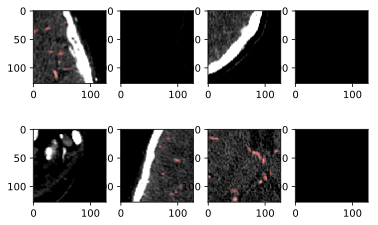

Epoch:4 step:0 loss: 0.693146
Epoch:4 step:1 loss: 0.693146
Epoch:4 step:2 loss: 0.693146
Epoch:4 step:3 loss: 0.693146
Epoch:4 step:4 loss: 0.693146
Epoch:4 step:5 loss: 0.693146
Epoch:4 step:6 loss: 0.693146
Epoch:4 step:7 loss: 0.693146
Epoch:4 step:8 loss: 0.693146
Epoch:4 step:9 loss: 0.693146
Epoch:4 step:10 loss: 0.693146
Epoch:4 step:11 loss: 0.693146
Epoch:4 step:12 loss: 0.693146
Epoch:4 step:13 loss: 0.693146
Epoch:4 step:14 loss: 0.693146
Epoch:4 step:15 loss: 0.693146
Epoch:4 step:16 loss: 0.693146
Epoch:4 step:17 loss: 0.693146
Epoch:4 step:18 loss: 0.693146
Epoch:4 step:19 loss: 0.693146
Epoch:4 step:20 loss: 0.693146
Epoch:4 step:21 loss: 0.693146
Epoch:4 step:22 loss: 0.693146
Epoch:4 step:23 loss: 0.693146
Epoch:4 step:24 loss: 0.693146
Epoch:4 step:25 loss: 0.693146
Epoch:4 step:26 loss: 0.693146
Epoch:4 step:27 loss: 0.693146
Epoch:4 step:28 loss: 0.693146
Epoch:4 step:29 loss: 0.693146
Epoch:4 step:30 loss: 0.693146
Epoch:4 step:31 loss: 0.693146
Epoch:4 step:32 lo

Epoch:4 step:259 loss: 0.693146
Epoch:4 step:260 loss: 0.693146
Epoch:4 step:261 loss: 0.693146
Epoch:4 step:262 loss: 0.693146
Epoch:4 step:263 loss: 0.693146
Epoch:4 step:264 loss: 0.693146
Epoch:4 step:265 loss: 0.693146
Epoch:4 step:266 loss: 0.693146
Epoch:4 step:267 loss: 0.693146
Epoch:4 step:268 loss: 0.693146
Epoch:4 step:269 loss: 0.693146
Epoch:4 step:270 loss: 0.693146
Epoch:4 step:271 loss: 0.693146
Epoch:4 step:272 loss: 0.693146
Epoch:4 step:273 loss: 0.693146
Epoch:4 step:274 loss: 0.693146
Epoch:4 step:275 loss: 0.693146
Epoch:4 step:276 loss: 0.693146
Epoch:4 step:277 loss: 0.693146
Epoch:4 step:278 loss: 0.693146
Epoch:4 step:279 loss: 0.693146
Epoch:4 step:280 loss: 0.693146
Epoch:4 step:281 loss: 0.693146
Epoch:4 step:282 loss: 0.693146
Epoch:4 step:283 loss: 0.693146
Epoch:4 step:284 loss: 0.693146
Epoch:4 step:285 loss: 0.693146
Epoch:4 step:286 loss: 0.693146
Epoch:4 step:287 loss: 0.693146
Epoch:4 step:288 loss: 0.693146
Epoch:4 step:289 loss: 0.693146
Epoch:4 

Epoch:4 step:515 loss: 0.693146
Epoch:4 step:516 loss: 0.693146
Epoch:4 step:517 loss: 0.693146
Epoch:4 step:518 loss: 0.693146
Epoch:4 step:519 loss: 0.693146
Epoch:4 step:520 loss: 0.693146
Epoch:4 step:521 loss: 0.693146
Epoch:4 step:522 loss: 0.693146
Epoch:4 step:523 loss: 0.693146
Epoch:4 step:524 loss: 0.693146
Epoch:4 step:525 loss: 0.693146
Epoch:4 step:526 loss: 0.693146
Epoch:4 step:527 loss: 0.693146
Epoch:4 step:528 loss: 0.693146
Epoch:4 step:529 loss: 0.693146
Epoch:4 step:530 loss: 0.693146
Epoch:4 step:531 loss: 0.693146
Epoch:4 step:532 loss: 0.693146
Epoch:4 step:533 loss: 0.693146
Epoch:4 step:534 loss: 0.693146
Epoch:4 step:535 loss: 0.693146
Epoch:4 step:536 loss: 0.693146
Epoch:4 step:537 loss: 0.693146
Epoch:4 step:538 loss: 0.693146
Epoch:4 step:539 loss: 0.693146
Epoch:4 step:540 loss: 0.693146
Epoch:4 step:541 loss: 0.693146
Epoch:4 step:542 loss: 0.693146
Epoch:4 step:543 loss: 0.693146
Epoch:4 step:544 loss: 0.693146
Epoch:4 step:545 loss: 0.693146
Epoch:4 

Epoch:4 step:771 loss: 0.693146
Epoch:4 step:772 loss: 0.693146
Epoch:4 step:773 loss: 0.693146
Epoch:4 step:774 loss: 0.693146
Epoch:4 step:775 loss: 0.693146
Epoch:4 step:776 loss: 0.693146
Epoch:4 step:777 loss: 0.693146
Epoch:4 step:778 loss: 0.693146
Epoch:4 step:779 loss: 0.693146
Epoch:4 step:780 loss: 0.693146
Epoch:4 step:781 loss: 0.693146
Epoch:4 step:782 loss: 0.693146
Epoch:4 step:783 loss: 0.693146
Epoch:4 step:784 loss: 0.693146
Epoch:4 step:785 loss: 0.693146
Epoch:4 step:786 loss: 0.693146
Epoch:4 step:787 loss: 0.693146
Epoch:4 step:788 loss: 0.693146
Epoch:4 step:789 loss: 0.693146
Epoch:4 step:790 loss: 0.693146
Epoch:4 step:791 loss: 0.693146
Epoch:4 step:792 loss: 0.693146
Epoch:4 step:793 loss: 0.693146
Epoch:4 step:794 loss: 0.693146
Epoch:4 step:795 loss: 0.693146
Epoch:4 step:796 loss: 0.693146
Epoch:4 step:797 loss: 0.693146
Epoch:4 step:798 loss: 0.693146
Epoch:4 step:799 loss: 0.693146
Test Epoch:4 step:0 loss: 0.693146tensor(1.5674e-09, grad_fn=<DivBackwar

Test Epoch:4 step:97 loss: 0.693146tensor(3.7931e-13, grad_fn=<DivBackward0>)
Test Epoch:4 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:4 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:4 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:4 step:101 loss: 0.693146tensor(7.0687e-10, grad_fn=<DivBackward0>)
Test Epoch:4 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:4 step:103 loss: 0.693146tensor(3.9040e-10, grad_fn=<DivBackward0>)
Test Epoch:4 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:4 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:4 step:106 loss: 0.693146tensor(8.9384e-10, grad_fn=<DivBackward0>)
Test Epoch:4 step:107 loss: 0.693146tensor(9.5476e-10, grad_fn=<DivBackward0>)
Test Epoch:4 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:4 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:4 step:110 loss: 0.693146tens

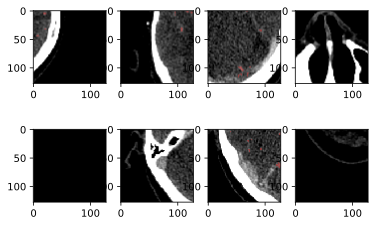

Epoch:5 step:0 loss: 0.693146
Epoch:5 step:1 loss: 0.693146
Epoch:5 step:2 loss: 0.693146
Epoch:5 step:3 loss: 0.693146
Epoch:5 step:4 loss: 0.693146
Epoch:5 step:5 loss: 0.693146
Epoch:5 step:6 loss: 0.693146
Epoch:5 step:7 loss: 0.693146
Epoch:5 step:8 loss: 0.693146
Epoch:5 step:9 loss: 0.693146
Epoch:5 step:10 loss: 0.693146
Epoch:5 step:11 loss: 0.693146
Epoch:5 step:12 loss: 0.693146
Epoch:5 step:13 loss: 0.693146
Epoch:5 step:14 loss: 0.693146
Epoch:5 step:15 loss: 0.693146
Epoch:5 step:16 loss: 0.693146
Epoch:5 step:17 loss: 0.693146
Epoch:5 step:18 loss: 0.693146
Epoch:5 step:19 loss: 0.693146
Epoch:5 step:20 loss: 0.693146
Epoch:5 step:21 loss: 0.693146
Epoch:5 step:22 loss: 0.693146
Epoch:5 step:23 loss: 0.693146
Epoch:5 step:24 loss: 0.693146
Epoch:5 step:25 loss: 0.693146
Epoch:5 step:26 loss: 0.693146
Epoch:5 step:27 loss: 0.693146
Epoch:5 step:28 loss: 0.693146
Epoch:5 step:29 loss: 0.693146
Epoch:5 step:30 loss: 0.693146
Epoch:5 step:31 loss: 0.693146
Epoch:5 step:32 lo

Epoch:5 step:259 loss: 0.693146
Epoch:5 step:260 loss: 0.693146
Epoch:5 step:261 loss: 0.693146
Epoch:5 step:262 loss: 0.693146
Epoch:5 step:263 loss: 0.693146
Epoch:5 step:264 loss: 0.693146
Epoch:5 step:265 loss: 0.693146
Epoch:5 step:266 loss: 0.693146
Epoch:5 step:267 loss: 0.693146
Epoch:5 step:268 loss: 0.693146
Epoch:5 step:269 loss: 0.693146
Epoch:5 step:270 loss: 0.693146
Epoch:5 step:271 loss: 0.693146
Epoch:5 step:272 loss: 0.693146
Epoch:5 step:273 loss: 0.693146
Epoch:5 step:274 loss: 0.693146
Epoch:5 step:275 loss: 0.693146
Epoch:5 step:276 loss: 0.693146
Epoch:5 step:277 loss: 0.693146
Epoch:5 step:278 loss: 0.693146
Epoch:5 step:279 loss: 0.693146
Epoch:5 step:280 loss: 0.693146
Epoch:5 step:281 loss: 0.693146
Epoch:5 step:282 loss: 0.693146
Epoch:5 step:283 loss: 0.693146
Epoch:5 step:284 loss: 0.693146
Epoch:5 step:285 loss: 0.693146
Epoch:5 step:286 loss: 0.693146
Epoch:5 step:287 loss: 0.693146
Epoch:5 step:288 loss: 0.693146
Epoch:5 step:289 loss: 0.693146
Epoch:5 

Epoch:5 step:515 loss: 0.693146
Epoch:5 step:516 loss: 0.693146
Epoch:5 step:517 loss: 0.693146
Epoch:5 step:518 loss: 0.693146
Epoch:5 step:519 loss: 0.693146
Epoch:5 step:520 loss: 0.693146
Epoch:5 step:521 loss: 0.693146
Epoch:5 step:522 loss: 0.693146
Epoch:5 step:523 loss: 0.693146
Epoch:5 step:524 loss: 0.693146
Epoch:5 step:525 loss: 0.693146
Epoch:5 step:526 loss: 0.693146
Epoch:5 step:527 loss: 0.693146
Epoch:5 step:528 loss: 0.693146
Epoch:5 step:529 loss: 0.693146
Epoch:5 step:530 loss: 0.693146
Epoch:5 step:531 loss: 0.693146
Epoch:5 step:532 loss: 0.693146
Epoch:5 step:533 loss: 0.693146
Epoch:5 step:534 loss: 0.693146
Epoch:5 step:535 loss: 0.693146
Epoch:5 step:536 loss: 0.693146
Epoch:5 step:537 loss: 0.693146
Epoch:5 step:538 loss: 0.693146
Epoch:5 step:539 loss: 0.693146
Epoch:5 step:540 loss: 0.693146
Epoch:5 step:541 loss: 0.693146
Epoch:5 step:542 loss: 0.693146
Epoch:5 step:543 loss: 0.693146
Epoch:5 step:544 loss: 0.693146
Epoch:5 step:545 loss: 0.693146
Epoch:5 

Epoch:5 step:771 loss: 0.693146
Epoch:5 step:772 loss: 0.693146
Epoch:5 step:773 loss: 0.693146
Epoch:5 step:774 loss: 0.693146
Epoch:5 step:775 loss: 0.693146
Epoch:5 step:776 loss: 0.693146
Epoch:5 step:777 loss: 0.693146
Epoch:5 step:778 loss: 0.693146
Epoch:5 step:779 loss: 0.693146
Epoch:5 step:780 loss: 0.693146
Epoch:5 step:781 loss: 0.693146
Epoch:5 step:782 loss: 0.693146
Epoch:5 step:783 loss: 0.693146
Epoch:5 step:784 loss: 0.693146
Epoch:5 step:785 loss: 0.693146
Epoch:5 step:786 loss: 0.693146
Epoch:5 step:787 loss: 0.693146
Epoch:5 step:788 loss: 0.693146
Epoch:5 step:789 loss: 0.693146
Epoch:5 step:790 loss: 0.693146
Epoch:5 step:791 loss: 0.693146
Epoch:5 step:792 loss: 0.693146
Epoch:5 step:793 loss: 0.693146
Epoch:5 step:794 loss: 0.693146
Epoch:5 step:795 loss: 0.693146
Epoch:5 step:796 loss: 0.693146
Epoch:5 step:797 loss: 0.693146
Epoch:5 step:798 loss: 0.693146
Epoch:5 step:799 loss: 0.693146
Test Epoch:5 step:0 loss: 0.693146tensor(1.6678e-09, grad_fn=<DivBackwar

Test Epoch:5 step:97 loss: 0.693146tensor(4.0335e-13, grad_fn=<DivBackward0>)
Test Epoch:5 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:5 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:5 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:5 step:101 loss: 0.693146tensor(7.1229e-10, grad_fn=<DivBackward0>)
Test Epoch:5 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:5 step:103 loss: 0.693146tensor(4.1904e-10, grad_fn=<DivBackward0>)
Test Epoch:5 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:5 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:5 step:106 loss: 0.693146tensor(9.4191e-10, grad_fn=<DivBackward0>)
Test Epoch:5 step:107 loss: 0.693146tensor(8.2867e-10, grad_fn=<DivBackward0>)
Test Epoch:5 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:5 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:5 step:110 loss: 0.693146tens

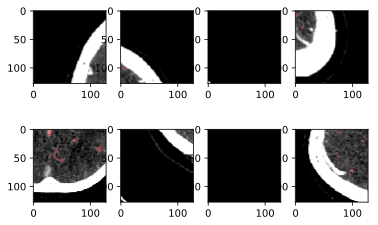

Epoch:6 step:0 loss: 0.693146
Epoch:6 step:1 loss: 0.693146
Epoch:6 step:2 loss: 0.693146
Epoch:6 step:3 loss: 0.693146
Epoch:6 step:4 loss: 0.693146
Epoch:6 step:5 loss: 0.693146
Epoch:6 step:6 loss: 0.693146
Epoch:6 step:7 loss: 0.693146
Epoch:6 step:8 loss: 0.693146
Epoch:6 step:9 loss: 0.693146
Epoch:6 step:10 loss: 0.693146
Epoch:6 step:11 loss: 0.693146
Epoch:6 step:12 loss: 0.693146
Epoch:6 step:13 loss: 0.693146
Epoch:6 step:14 loss: 0.693146
Epoch:6 step:15 loss: 0.693146
Epoch:6 step:16 loss: 0.693146
Epoch:6 step:17 loss: 0.693146
Epoch:6 step:18 loss: 0.693146
Epoch:6 step:19 loss: 0.693146
Epoch:6 step:20 loss: 0.693146
Epoch:6 step:21 loss: 0.693146
Epoch:6 step:22 loss: 0.693146
Epoch:6 step:23 loss: 0.693146
Epoch:6 step:24 loss: 0.693146
Epoch:6 step:25 loss: 0.693146
Epoch:6 step:26 loss: 0.693146
Epoch:6 step:27 loss: 0.693146
Epoch:6 step:28 loss: 0.693146
Epoch:6 step:29 loss: 0.693146
Epoch:6 step:30 loss: 0.693146
Epoch:6 step:31 loss: 0.693146
Epoch:6 step:32 lo

Epoch:6 step:259 loss: 0.693146
Epoch:6 step:260 loss: 0.693146
Epoch:6 step:261 loss: 0.693146
Epoch:6 step:262 loss: 0.693146
Epoch:6 step:263 loss: 0.693146
Epoch:6 step:264 loss: 0.693146
Epoch:6 step:265 loss: 0.693146
Epoch:6 step:266 loss: 0.693146
Epoch:6 step:267 loss: 0.693146
Epoch:6 step:268 loss: 0.693146
Epoch:6 step:269 loss: 0.693146
Epoch:6 step:270 loss: 0.693146
Epoch:6 step:271 loss: 0.693146
Epoch:6 step:272 loss: 0.693146
Epoch:6 step:273 loss: 0.693146
Epoch:6 step:274 loss: 0.693146
Epoch:6 step:275 loss: 0.693146
Epoch:6 step:276 loss: 0.693146
Epoch:6 step:277 loss: 0.693146
Epoch:6 step:278 loss: 0.693146
Epoch:6 step:279 loss: 0.693146
Epoch:6 step:280 loss: 0.693146
Epoch:6 step:281 loss: 0.693146
Epoch:6 step:282 loss: 0.693146
Epoch:6 step:283 loss: 0.693146
Epoch:6 step:284 loss: 0.693146
Epoch:6 step:285 loss: 0.693146
Epoch:6 step:286 loss: 0.693146
Epoch:6 step:287 loss: 0.693146
Epoch:6 step:288 loss: 0.693146
Epoch:6 step:289 loss: 0.693146
Epoch:6 

Epoch:6 step:515 loss: 0.693146
Epoch:6 step:516 loss: 0.693146
Epoch:6 step:517 loss: 0.693146
Epoch:6 step:518 loss: 0.693146
Epoch:6 step:519 loss: 0.693146
Epoch:6 step:520 loss: 0.693146
Epoch:6 step:521 loss: 0.693146
Epoch:6 step:522 loss: 0.693146
Epoch:6 step:523 loss: 0.693146
Epoch:6 step:524 loss: 0.693146
Epoch:6 step:525 loss: 0.693146
Epoch:6 step:526 loss: 0.693146
Epoch:6 step:527 loss: 0.693146
Epoch:6 step:528 loss: 0.693146
Epoch:6 step:529 loss: 0.693146
Epoch:6 step:530 loss: 0.693146
Epoch:6 step:531 loss: 0.693146
Epoch:6 step:532 loss: 0.693146
Epoch:6 step:533 loss: 0.693146
Epoch:6 step:534 loss: 0.693146
Epoch:6 step:535 loss: 0.693146
Epoch:6 step:536 loss: 0.693146
Epoch:6 step:537 loss: 0.693146
Epoch:6 step:538 loss: 0.693146
Epoch:6 step:539 loss: 0.693146
Epoch:6 step:540 loss: 0.693146
Epoch:6 step:541 loss: 0.693146
Epoch:6 step:542 loss: 0.693146
Epoch:6 step:543 loss: 0.693146
Epoch:6 step:544 loss: 0.693146
Epoch:6 step:545 loss: 0.693146
Epoch:6 

Epoch:6 step:771 loss: 0.693146
Epoch:6 step:772 loss: 0.693146
Epoch:6 step:773 loss: 0.693146
Epoch:6 step:774 loss: 0.693146
Epoch:6 step:775 loss: 0.693146
Epoch:6 step:776 loss: 0.693146
Epoch:6 step:777 loss: 0.693146
Epoch:6 step:778 loss: 0.693146
Epoch:6 step:779 loss: 0.693146
Epoch:6 step:780 loss: 0.693146
Epoch:6 step:781 loss: 0.693146
Epoch:6 step:782 loss: 0.693146
Epoch:6 step:783 loss: 0.693146
Epoch:6 step:784 loss: 0.693146
Epoch:6 step:785 loss: 0.693146
Epoch:6 step:786 loss: 0.693146
Epoch:6 step:787 loss: 0.693146
Epoch:6 step:788 loss: 0.693146
Epoch:6 step:789 loss: 0.693146
Epoch:6 step:790 loss: 0.693146
Epoch:6 step:791 loss: 0.693146
Epoch:6 step:792 loss: 0.693146
Epoch:6 step:793 loss: 0.693146
Epoch:6 step:794 loss: 0.693146
Epoch:6 step:795 loss: 0.693146
Epoch:6 step:796 loss: 0.693146
Epoch:6 step:797 loss: 0.693146
Epoch:6 step:798 loss: 0.693146
Epoch:6 step:799 loss: 0.693146
Test Epoch:6 step:0 loss: 0.693146tensor(1.7459e-09, grad_fn=<DivBackwar

Test Epoch:6 step:97 loss: 0.693146tensor(4.2010e-13, grad_fn=<DivBackward0>)
Test Epoch:6 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:6 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:6 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:6 step:101 loss: 0.693146tensor(7.1551e-10, grad_fn=<DivBackward0>)
Test Epoch:6 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:6 step:103 loss: 0.693146tensor(4.4119e-10, grad_fn=<DivBackward0>)
Test Epoch:6 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:6 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:6 step:106 loss: 0.693146tensor(9.7893e-10, grad_fn=<DivBackward0>)
Test Epoch:6 step:107 loss: 0.693146tensor(7.2571e-10, grad_fn=<DivBackward0>)
Test Epoch:6 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:6 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:6 step:110 loss: 0.693146tens

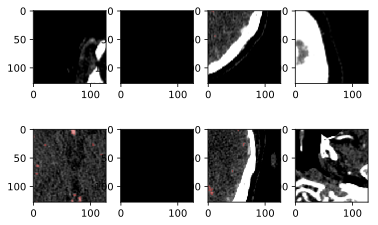

Epoch:7 step:0 loss: 0.693146
Epoch:7 step:1 loss: 0.693146
Epoch:7 step:2 loss: 0.693146
Epoch:7 step:3 loss: 0.693146
Epoch:7 step:4 loss: 0.693146
Epoch:7 step:5 loss: 0.693146
Epoch:7 step:6 loss: 0.693146
Epoch:7 step:7 loss: 0.693146
Epoch:7 step:8 loss: 0.693146
Epoch:7 step:9 loss: 0.693146
Epoch:7 step:10 loss: 0.693146
Epoch:7 step:11 loss: 0.693146
Epoch:7 step:12 loss: 0.693146
Epoch:7 step:13 loss: 0.693146
Epoch:7 step:14 loss: 0.693146
Epoch:7 step:15 loss: 0.693146
Epoch:7 step:16 loss: 0.693146
Epoch:7 step:17 loss: 0.693146
Epoch:7 step:18 loss: 0.693146
Epoch:7 step:19 loss: 0.693146
Epoch:7 step:20 loss: 0.693146
Epoch:7 step:21 loss: 0.693146
Epoch:7 step:22 loss: 0.693146
Epoch:7 step:23 loss: 0.693146
Epoch:7 step:24 loss: 0.693146
Epoch:7 step:25 loss: 0.693146
Epoch:7 step:26 loss: 0.693146
Epoch:7 step:27 loss: 0.693146
Epoch:7 step:28 loss: 0.693146
Epoch:7 step:29 loss: 0.693146
Epoch:7 step:30 loss: 0.693146
Epoch:7 step:31 loss: 0.693146
Epoch:7 step:32 lo

Epoch:7 step:259 loss: 0.693146
Epoch:7 step:260 loss: 0.693146
Epoch:7 step:261 loss: 0.693146
Epoch:7 step:262 loss: 0.693146
Epoch:7 step:263 loss: 0.693146
Epoch:7 step:264 loss: 0.693146
Epoch:7 step:265 loss: 0.693146
Epoch:7 step:266 loss: 0.693146
Epoch:7 step:267 loss: 0.693146
Epoch:7 step:268 loss: 0.693146
Epoch:7 step:269 loss: 0.693146
Epoch:7 step:270 loss: 0.693146
Epoch:7 step:271 loss: 0.693146
Epoch:7 step:272 loss: 0.693146
Epoch:7 step:273 loss: 0.693146
Epoch:7 step:274 loss: 0.693146
Epoch:7 step:275 loss: 0.693146
Epoch:7 step:276 loss: 0.693146
Epoch:7 step:277 loss: 0.693146
Epoch:7 step:278 loss: 0.693146
Epoch:7 step:279 loss: 0.693146
Epoch:7 step:280 loss: 0.693146
Epoch:7 step:281 loss: 0.693146
Epoch:7 step:282 loss: 0.693146
Epoch:7 step:283 loss: 0.693146
Epoch:7 step:284 loss: 0.693146
Epoch:7 step:285 loss: 0.693146
Epoch:7 step:286 loss: 0.693146
Epoch:7 step:287 loss: 0.693146
Epoch:7 step:288 loss: 0.693146
Epoch:7 step:289 loss: 0.693146
Epoch:7 

Epoch:7 step:515 loss: 0.693146
Epoch:7 step:516 loss: 0.693146
Epoch:7 step:517 loss: 0.693146
Epoch:7 step:518 loss: 0.693146
Epoch:7 step:519 loss: 0.693146
Epoch:7 step:520 loss: 0.693146
Epoch:7 step:521 loss: 0.693146
Epoch:7 step:522 loss: 0.693146
Epoch:7 step:523 loss: 0.693146
Epoch:7 step:524 loss: 0.693146
Epoch:7 step:525 loss: 0.693146
Epoch:7 step:526 loss: 0.693146
Epoch:7 step:527 loss: 0.693146
Epoch:7 step:528 loss: 0.693146
Epoch:7 step:529 loss: 0.693146
Epoch:7 step:530 loss: 0.693146
Epoch:7 step:531 loss: 0.693146
Epoch:7 step:532 loss: 0.693146
Epoch:7 step:533 loss: 0.693146
Epoch:7 step:534 loss: 0.693146
Epoch:7 step:535 loss: 0.693146
Epoch:7 step:536 loss: 0.693146
Epoch:7 step:537 loss: 0.693146
Epoch:7 step:538 loss: 0.693146
Epoch:7 step:539 loss: 0.693146
Epoch:7 step:540 loss: 0.693146
Epoch:7 step:541 loss: 0.693146
Epoch:7 step:542 loss: 0.693146
Epoch:7 step:543 loss: 0.693146
Epoch:7 step:544 loss: 0.693146
Epoch:7 step:545 loss: 0.693146
Epoch:7 

Epoch:7 step:771 loss: 0.693146
Epoch:7 step:772 loss: 0.693146
Epoch:7 step:773 loss: 0.693146
Epoch:7 step:774 loss: 0.693146
Epoch:7 step:775 loss: 0.693146
Epoch:7 step:776 loss: 0.693146
Epoch:7 step:777 loss: 0.693146
Epoch:7 step:778 loss: 0.693146
Epoch:7 step:779 loss: 0.693146
Epoch:7 step:780 loss: 0.693146
Epoch:7 step:781 loss: 0.693146
Epoch:7 step:782 loss: 0.693146
Epoch:7 step:783 loss: 0.693146
Epoch:7 step:784 loss: 0.693146
Epoch:7 step:785 loss: 0.693146
Epoch:7 step:786 loss: 0.693146
Epoch:7 step:787 loss: 0.693146
Epoch:7 step:788 loss: 0.693146
Epoch:7 step:789 loss: 0.693146
Epoch:7 step:790 loss: 0.693146
Epoch:7 step:791 loss: 0.693146
Epoch:7 step:792 loss: 0.693146
Epoch:7 step:793 loss: 0.693146
Epoch:7 step:794 loss: 0.693146
Epoch:7 step:795 loss: 0.693146
Epoch:7 step:796 loss: 0.693146
Epoch:7 step:797 loss: 0.693146
Epoch:7 step:798 loss: 0.693146
Epoch:7 step:799 loss: 0.693146
Test Epoch:7 step:0 loss: 0.693146tensor(1.7611e-09, grad_fn=<DivBackwar

Test Epoch:7 step:97 loss: 0.693146tensor(4.2898e-13, grad_fn=<DivBackward0>)
Test Epoch:7 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:7 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:7 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:7 step:101 loss: 0.693146tensor(6.9206e-10, grad_fn=<DivBackward0>)
Test Epoch:7 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:7 step:103 loss: 0.693146tensor(4.4551e-10, grad_fn=<DivBackward0>)
Test Epoch:7 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:7 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:7 step:106 loss: 0.693146tensor(9.7703e-10, grad_fn=<DivBackward0>)
Test Epoch:7 step:107 loss: 0.693146tensor(6.3349e-10, grad_fn=<DivBackward0>)
Test Epoch:7 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:7 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:7 step:110 loss: 0.693146tens

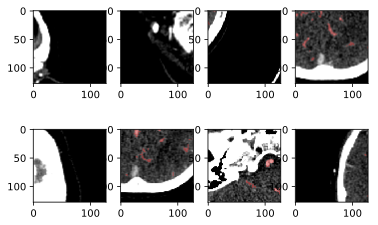

Epoch:8 step:0 loss: 0.693146
Epoch:8 step:1 loss: 0.693146
Epoch:8 step:2 loss: 0.693146
Epoch:8 step:3 loss: 0.693146
Epoch:8 step:4 loss: 0.693146
Epoch:8 step:5 loss: 0.693146
Epoch:8 step:6 loss: 0.693146
Epoch:8 step:7 loss: 0.693146
Epoch:8 step:8 loss: 0.693146
Epoch:8 step:9 loss: 0.693146
Epoch:8 step:10 loss: 0.693146
Epoch:8 step:11 loss: 0.693146
Epoch:8 step:12 loss: 0.693146
Epoch:8 step:13 loss: 0.693146
Epoch:8 step:14 loss: 0.693146
Epoch:8 step:15 loss: 0.693146
Epoch:8 step:16 loss: 0.693146
Epoch:8 step:17 loss: 0.693146
Epoch:8 step:18 loss: 0.693146
Epoch:8 step:19 loss: 0.693146
Epoch:8 step:20 loss: 0.693146
Epoch:8 step:21 loss: 0.693146
Epoch:8 step:22 loss: 0.693146
Epoch:8 step:23 loss: 0.693146
Epoch:8 step:24 loss: 0.693146
Epoch:8 step:25 loss: 0.693146
Epoch:8 step:26 loss: 0.693146
Epoch:8 step:27 loss: 0.693146
Epoch:8 step:28 loss: 0.693146
Epoch:8 step:29 loss: 0.693146
Epoch:8 step:30 loss: 0.693146
Epoch:8 step:31 loss: 0.693146
Epoch:8 step:32 lo

Epoch:8 step:259 loss: 0.693146
Epoch:8 step:260 loss: 0.693146
Epoch:8 step:261 loss: 0.693146
Epoch:8 step:262 loss: 0.693146
Epoch:8 step:263 loss: 0.693146
Epoch:8 step:264 loss: 0.693146
Epoch:8 step:265 loss: 0.693146
Epoch:8 step:266 loss: 0.693146
Epoch:8 step:267 loss: 0.693146
Epoch:8 step:268 loss: 0.693146
Epoch:8 step:269 loss: 0.693146
Epoch:8 step:270 loss: 0.693146
Epoch:8 step:271 loss: 0.693146
Epoch:8 step:272 loss: 0.693146
Epoch:8 step:273 loss: 0.693146
Epoch:8 step:274 loss: 0.693146
Epoch:8 step:275 loss: 0.693146
Epoch:8 step:276 loss: 0.693146
Epoch:8 step:277 loss: 0.693146
Epoch:8 step:278 loss: 0.693146
Epoch:8 step:279 loss: 0.693146
Epoch:8 step:280 loss: 0.693146
Epoch:8 step:281 loss: 0.693146
Epoch:8 step:282 loss: 0.693146
Epoch:8 step:283 loss: 0.693146
Epoch:8 step:284 loss: 0.693146
Epoch:8 step:285 loss: 0.693146
Epoch:8 step:286 loss: 0.693146
Epoch:8 step:287 loss: 0.693146
Epoch:8 step:288 loss: 0.693146
Epoch:8 step:289 loss: 0.693146
Epoch:8 

Epoch:8 step:515 loss: 0.693146
Epoch:8 step:516 loss: 0.693146
Epoch:8 step:517 loss: 0.693146
Epoch:8 step:518 loss: 0.693146
Epoch:8 step:519 loss: 0.693146
Epoch:8 step:520 loss: 0.693146
Epoch:8 step:521 loss: 0.693146
Epoch:8 step:522 loss: 0.693146
Epoch:8 step:523 loss: 0.693146
Epoch:8 step:524 loss: 0.693146
Epoch:8 step:525 loss: 0.693146
Epoch:8 step:526 loss: 0.693146
Epoch:8 step:527 loss: 0.693146
Epoch:8 step:528 loss: 0.693146
Epoch:8 step:529 loss: 0.693146
Epoch:8 step:530 loss: 0.693146
Epoch:8 step:531 loss: 0.693146
Epoch:8 step:532 loss: 0.693146
Epoch:8 step:533 loss: 0.693146
Epoch:8 step:534 loss: 0.693146
Epoch:8 step:535 loss: 0.693146
Epoch:8 step:536 loss: 0.693146
Epoch:8 step:537 loss: 0.693146
Epoch:8 step:538 loss: 0.693146
Epoch:8 step:539 loss: 0.693146
Epoch:8 step:540 loss: 0.693146
Epoch:8 step:541 loss: 0.693146
Epoch:8 step:542 loss: 0.693146
Epoch:8 step:543 loss: 0.693146
Epoch:8 step:544 loss: 0.693146
Epoch:8 step:545 loss: 0.693146
Epoch:8 

Epoch:8 step:771 loss: 0.693146
Epoch:8 step:772 loss: 0.693146
Epoch:8 step:773 loss: 0.693146
Epoch:8 step:774 loss: 0.693146
Epoch:8 step:775 loss: 0.693146
Epoch:8 step:776 loss: 0.693146
Epoch:8 step:777 loss: 0.693146
Epoch:8 step:778 loss: 0.693146
Epoch:8 step:779 loss: 0.693146
Epoch:8 step:780 loss: 0.693146
Epoch:8 step:781 loss: 0.693146
Epoch:8 step:782 loss: 0.693146
Epoch:8 step:783 loss: 0.693146
Epoch:8 step:784 loss: 0.693146
Epoch:8 step:785 loss: 0.693146
Epoch:8 step:786 loss: 0.693146
Epoch:8 step:787 loss: 0.693146
Epoch:8 step:788 loss: 0.693146
Epoch:8 step:789 loss: 0.693146
Epoch:8 step:790 loss: 0.693146
Epoch:8 step:791 loss: 0.693146
Epoch:8 step:792 loss: 0.693146
Epoch:8 step:793 loss: 0.693146
Epoch:8 step:794 loss: 0.693146
Epoch:8 step:795 loss: 0.693146
Epoch:8 step:796 loss: 0.693146
Epoch:8 step:797 loss: 0.693146
Epoch:8 step:798 loss: 0.693146
Epoch:8 step:799 loss: 0.693146
Test Epoch:8 step:0 loss: 0.693146tensor(1.6823e-09, grad_fn=<DivBackwar

Test Epoch:8 step:97 loss: 0.693146tensor(4.2504e-13, grad_fn=<DivBackward0>)
Test Epoch:8 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:8 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:8 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:8 step:101 loss: 0.693146tensor(6.3417e-10, grad_fn=<DivBackward0>)
Test Epoch:8 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:8 step:103 loss: 0.693146tensor(4.2370e-10, grad_fn=<DivBackward0>)
Test Epoch:8 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:8 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:8 step:106 loss: 0.693146tensor(9.2362e-10, grad_fn=<DivBackward0>)
Test Epoch:8 step:107 loss: 0.693146tensor(5.4269e-10, grad_fn=<DivBackward0>)
Test Epoch:8 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:8 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:8 step:110 loss: 0.693146tens

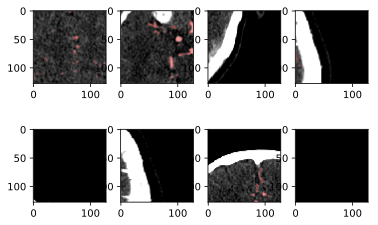

Epoch:9 step:0 loss: 0.693146
Epoch:9 step:1 loss: 0.693146
Epoch:9 step:2 loss: 0.693146
Epoch:9 step:3 loss: 0.693146
Epoch:9 step:4 loss: 0.693146
Epoch:9 step:5 loss: 0.693146
Epoch:9 step:6 loss: 0.693146
Epoch:9 step:7 loss: 0.693146
Epoch:9 step:8 loss: 0.693146
Epoch:9 step:9 loss: 0.693146
Epoch:9 step:10 loss: 0.693146
Epoch:9 step:11 loss: 0.693146
Epoch:9 step:12 loss: 0.693146
Epoch:9 step:13 loss: 0.693146
Epoch:9 step:14 loss: 0.693146
Epoch:9 step:15 loss: 0.693146
Epoch:9 step:16 loss: 0.693146
Epoch:9 step:17 loss: 0.693146
Epoch:9 step:18 loss: 0.693146
Epoch:9 step:19 loss: 0.693146
Epoch:9 step:20 loss: 0.693146
Epoch:9 step:21 loss: 0.693146
Epoch:9 step:22 loss: 0.693146
Epoch:9 step:23 loss: 0.693146
Epoch:9 step:24 loss: 0.693146
Epoch:9 step:25 loss: 0.693146
Epoch:9 step:26 loss: 0.693146
Epoch:9 step:27 loss: 0.693146
Epoch:9 step:28 loss: 0.693146
Epoch:9 step:29 loss: 0.693146
Epoch:9 step:30 loss: 0.693146
Epoch:9 step:31 loss: 0.693146
Epoch:9 step:32 lo

Epoch:9 step:259 loss: 0.693146
Epoch:9 step:260 loss: 0.693146
Epoch:9 step:261 loss: 0.693146
Epoch:9 step:262 loss: 0.693146
Epoch:9 step:263 loss: 0.693146
Epoch:9 step:264 loss: 0.693146
Epoch:9 step:265 loss: 0.693146
Epoch:9 step:266 loss: 0.693146
Epoch:9 step:267 loss: 0.693146
Epoch:9 step:268 loss: 0.693146
Epoch:9 step:269 loss: 0.693146
Epoch:9 step:270 loss: 0.693146
Epoch:9 step:271 loss: 0.693146
Epoch:9 step:272 loss: 0.693146
Epoch:9 step:273 loss: 0.693146
Epoch:9 step:274 loss: 0.693146
Epoch:9 step:275 loss: 0.693146
Epoch:9 step:276 loss: 0.693146
Epoch:9 step:277 loss: 0.693146
Epoch:9 step:278 loss: 0.693146
Epoch:9 step:279 loss: 0.693146
Epoch:9 step:280 loss: 0.693146
Epoch:9 step:281 loss: 0.693146
Epoch:9 step:282 loss: 0.693146
Epoch:9 step:283 loss: 0.693146
Epoch:9 step:284 loss: 0.693146
Epoch:9 step:285 loss: 0.693146
Epoch:9 step:286 loss: 0.693146
Epoch:9 step:287 loss: 0.693146
Epoch:9 step:288 loss: 0.693146
Epoch:9 step:289 loss: 0.693146
Epoch:9 

Epoch:9 step:515 loss: 0.693146
Epoch:9 step:516 loss: 0.693146
Epoch:9 step:517 loss: 0.693146
Epoch:9 step:518 loss: 0.693146
Epoch:9 step:519 loss: 0.693146
Epoch:9 step:520 loss: 0.693146
Epoch:9 step:521 loss: 0.693146
Epoch:9 step:522 loss: 0.693146
Epoch:9 step:523 loss: 0.693146
Epoch:9 step:524 loss: 0.693146
Epoch:9 step:525 loss: 0.693146
Epoch:9 step:526 loss: 0.693146
Epoch:9 step:527 loss: 0.693146
Epoch:9 step:528 loss: 0.693146
Epoch:9 step:529 loss: 0.693146
Epoch:9 step:530 loss: 0.693146
Epoch:9 step:531 loss: 0.693146
Epoch:9 step:532 loss: 0.693146
Epoch:9 step:533 loss: 0.693146
Epoch:9 step:534 loss: 0.693146
Epoch:9 step:535 loss: 0.693146
Epoch:9 step:536 loss: 0.693146
Epoch:9 step:537 loss: 0.693146
Epoch:9 step:538 loss: 0.693146
Epoch:9 step:539 loss: 0.693146
Epoch:9 step:540 loss: 0.693146
Epoch:9 step:541 loss: 0.693146
Epoch:9 step:542 loss: 0.693146
Epoch:9 step:543 loss: 0.693146
Epoch:9 step:544 loss: 0.693146
Epoch:9 step:545 loss: 0.693146
Epoch:9 

Epoch:9 step:771 loss: 0.693146
Epoch:9 step:772 loss: 0.693146
Epoch:9 step:773 loss: 0.693146
Epoch:9 step:774 loss: 0.693146
Epoch:9 step:775 loss: 0.693146
Epoch:9 step:776 loss: 0.693146
Epoch:9 step:777 loss: 0.693146
Epoch:9 step:778 loss: 0.693146
Epoch:9 step:779 loss: 0.693146
Epoch:9 step:780 loss: 0.693146
Epoch:9 step:781 loss: 0.693146
Epoch:9 step:782 loss: 0.693146
Epoch:9 step:783 loss: 0.693146
Epoch:9 step:784 loss: 0.693146
Epoch:9 step:785 loss: 0.693146
Epoch:9 step:786 loss: 0.693146
Epoch:9 step:787 loss: 0.693146
Epoch:9 step:788 loss: 0.693146
Epoch:9 step:789 loss: 0.693146
Epoch:9 step:790 loss: 0.693146
Epoch:9 step:791 loss: 0.693146
Epoch:9 step:792 loss: 0.693146
Epoch:9 step:793 loss: 0.693146
Epoch:9 step:794 loss: 0.693146
Epoch:9 step:795 loss: 0.693146
Epoch:9 step:796 loss: 0.693146
Epoch:9 step:797 loss: 0.693146
Epoch:9 step:798 loss: 0.693146
Epoch:9 step:799 loss: 0.693146
Test Epoch:9 step:0 loss: 0.693146tensor(1.4987e-09, grad_fn=<DivBackwar

Test Epoch:9 step:97 loss: 0.693146tensor(4.0097e-13, grad_fn=<DivBackward0>)
Test Epoch:9 step:98 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:9 step:99 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:9 step:100 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:9 step:101 loss: 0.693146tensor(5.4343e-10, grad_fn=<DivBackward0>)
Test Epoch:9 step:102 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:9 step:103 loss: 0.693146tensor(3.7566e-10, grad_fn=<DivBackward0>)
Test Epoch:9 step:104 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:9 step:105 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:9 step:106 loss: 0.693146tensor(8.1531e-10, grad_fn=<DivBackward0>)
Test Epoch:9 step:107 loss: 0.693146tensor(4.5057e-10, grad_fn=<DivBackward0>)
Test Epoch:9 step:108 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:9 step:109 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:9 step:110 loss: 0.693146tens

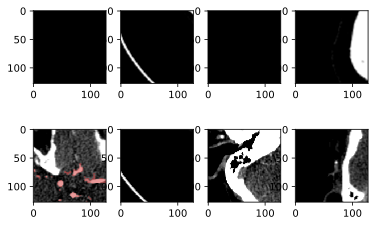

Epoch:10 step:0 loss: 0.693146
Epoch:10 step:1 loss: 0.693146
Epoch:10 step:2 loss: 0.693146
Epoch:10 step:3 loss: 0.693146
Epoch:10 step:4 loss: 0.693146
Epoch:10 step:5 loss: 0.693146
Epoch:10 step:6 loss: 0.693146
Epoch:10 step:7 loss: 0.693146
Epoch:10 step:8 loss: 0.693146
Epoch:10 step:9 loss: 0.693146
Epoch:10 step:10 loss: 0.693146
Epoch:10 step:11 loss: 0.693146
Epoch:10 step:12 loss: 0.693146
Epoch:10 step:13 loss: 0.693146
Epoch:10 step:14 loss: 0.693146
Epoch:10 step:15 loss: 0.693146
Epoch:10 step:16 loss: 0.693146
Epoch:10 step:17 loss: 0.693146
Epoch:10 step:18 loss: 0.693146
Epoch:10 step:19 loss: 0.693146
Epoch:10 step:20 loss: 0.693146
Epoch:10 step:21 loss: 0.693146
Epoch:10 step:22 loss: 0.693146
Epoch:10 step:23 loss: 0.693146
Epoch:10 step:24 loss: 0.693146
Epoch:10 step:25 loss: 0.693146
Epoch:10 step:26 loss: 0.693146
Epoch:10 step:27 loss: 0.693146
Epoch:10 step:28 loss: 0.693146
Epoch:10 step:29 loss: 0.693146
Epoch:10 step:30 loss: 0.693146
Epoch:10 step:31 l

Epoch:10 step:251 loss: 0.693146
Epoch:10 step:252 loss: 0.693146
Epoch:10 step:253 loss: 0.693146
Epoch:10 step:254 loss: 0.693146
Epoch:10 step:255 loss: 0.693146
Epoch:10 step:256 loss: 0.693146
Epoch:10 step:257 loss: 0.693146
Epoch:10 step:258 loss: 0.693146
Epoch:10 step:259 loss: 0.693146
Epoch:10 step:260 loss: 0.693146
Epoch:10 step:261 loss: 0.693146
Epoch:10 step:262 loss: 0.693146
Epoch:10 step:263 loss: 0.693146
Epoch:10 step:264 loss: 0.693146
Epoch:10 step:265 loss: 0.693146
Epoch:10 step:266 loss: 0.693146
Epoch:10 step:267 loss: 0.693146
Epoch:10 step:268 loss: 0.693146
Epoch:10 step:269 loss: 0.693146
Epoch:10 step:270 loss: 0.693146
Epoch:10 step:271 loss: 0.693146
Epoch:10 step:272 loss: 0.693146
Epoch:10 step:273 loss: 0.693146
Epoch:10 step:274 loss: 0.693146
Epoch:10 step:275 loss: 0.693146
Epoch:10 step:276 loss: 0.693146
Epoch:10 step:277 loss: 0.693146
Epoch:10 step:278 loss: 0.693146
Epoch:10 step:279 loss: 0.693146
Epoch:10 step:280 loss: 0.693146
Epoch:10 s

Epoch:10 step:499 loss: 0.693146
Epoch:10 step:500 loss: 0.693146
Epoch:10 step:501 loss: 0.693146
Epoch:10 step:502 loss: 0.693146
Epoch:10 step:503 loss: 0.693146
Epoch:10 step:504 loss: 0.693146
Epoch:10 step:505 loss: 0.693146
Epoch:10 step:506 loss: 0.693146
Epoch:10 step:507 loss: 0.693146
Epoch:10 step:508 loss: 0.693146
Epoch:10 step:509 loss: 0.693146
Epoch:10 step:510 loss: 0.693146
Epoch:10 step:511 loss: 0.693146
Epoch:10 step:512 loss: 0.693146
Epoch:10 step:513 loss: 0.693146
Epoch:10 step:514 loss: 0.693146
Epoch:10 step:515 loss: 0.693146
Epoch:10 step:516 loss: 0.693146
Epoch:10 step:517 loss: 0.693146
Epoch:10 step:518 loss: 0.693146
Epoch:10 step:519 loss: 0.693146
Epoch:10 step:520 loss: 0.693146
Epoch:10 step:521 loss: 0.693146
Epoch:10 step:522 loss: 0.693146
Epoch:10 step:523 loss: 0.693146
Epoch:10 step:524 loss: 0.693146
Epoch:10 step:525 loss: 0.693146
Epoch:10 step:526 loss: 0.693146
Epoch:10 step:527 loss: 0.693146
Epoch:10 step:528 loss: 0.693146
Epoch:10 s

Epoch:10 step:747 loss: 0.693146
Epoch:10 step:748 loss: 0.693146
Epoch:10 step:749 loss: 0.693146
Epoch:10 step:750 loss: 0.693146
Epoch:10 step:751 loss: 0.693146
Epoch:10 step:752 loss: 0.693146
Epoch:10 step:753 loss: 0.693146
Epoch:10 step:754 loss: 0.693146
Epoch:10 step:755 loss: 0.693146
Epoch:10 step:756 loss: 0.693146
Epoch:10 step:757 loss: 0.693146
Epoch:10 step:758 loss: 0.693146
Epoch:10 step:759 loss: 0.693146
Epoch:10 step:760 loss: 0.693146
Epoch:10 step:761 loss: 0.693146
Epoch:10 step:762 loss: 0.693146
Epoch:10 step:763 loss: 0.693146
Epoch:10 step:764 loss: 0.693146
Epoch:10 step:765 loss: 0.693146
Epoch:10 step:766 loss: 0.693146
Epoch:10 step:767 loss: 0.693146
Epoch:10 step:768 loss: 0.693146
Epoch:10 step:769 loss: 0.693146
Epoch:10 step:770 loss: 0.693146
Epoch:10 step:771 loss: 0.693146
Epoch:10 step:772 loss: 0.693146
Epoch:10 step:773 loss: 0.693146
Epoch:10 step:774 loss: 0.693146
Epoch:10 step:775 loss: 0.693146
Epoch:10 step:776 loss: 0.693146
Epoch:10 s

Test Epoch:10 step:85 loss: 0.693146tensor(2.9760e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:86 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:10 step:87 loss: 0.693146tensor(4.4322e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:88 loss: 0.693146tensor(1.0945e-09, grad_fn=<DivBackward0>)
Test Epoch:10 step:89 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:10 step:90 loss: 0.693146tensor(1.7726e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:91 loss: 0.693146tensor(2.4434e-09, grad_fn=<DivBackward0>)
Test Epoch:10 step:92 loss: 0.693146tensor(1.8352e-12, grad_fn=<DivBackward0>)
Test Epoch:10 step:93 loss: 0.693146tensor(3.7659e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:94 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:10 step:95 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:10 step:96 loss: 0.693146tensor(3.7835e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:97 loss: 0.693146tensor(3.5547e-13, grad_fn=<DivBackward0>)
Test 

Test Epoch:10 step:192 loss: 0.693146tensor(4.0083e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:193 loss: 0.693146tensor(4.8225e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:194 loss: 0.693146tensor(3.1403e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:195 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:10 step:196 loss: 0.693146tensor(7.0324e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:197 loss: 0.693146tensor(5.5393e-10, grad_fn=<DivBackward0>)
Test Epoch:10 step:198 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:10 step:199 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)


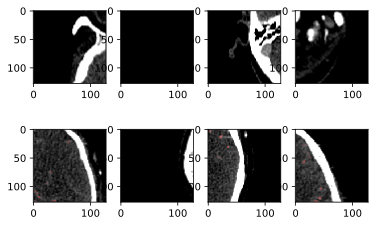

Epoch:11 step:0 loss: 0.693146
Epoch:11 step:1 loss: 0.693146
Epoch:11 step:2 loss: 0.693146
Epoch:11 step:3 loss: 0.693146
Epoch:11 step:4 loss: 0.693146
Epoch:11 step:5 loss: 0.693146
Epoch:11 step:6 loss: 0.693146
Epoch:11 step:7 loss: 0.693146
Epoch:11 step:8 loss: 0.693146
Epoch:11 step:9 loss: 0.693146
Epoch:11 step:10 loss: 0.693146
Epoch:11 step:11 loss: 0.693146
Epoch:11 step:12 loss: 0.693146
Epoch:11 step:13 loss: 0.693146
Epoch:11 step:14 loss: 0.693146
Epoch:11 step:15 loss: 0.693146
Epoch:11 step:16 loss: 0.693146
Epoch:11 step:17 loss: 0.693146
Epoch:11 step:18 loss: 0.693146
Epoch:11 step:19 loss: 0.693146
Epoch:11 step:20 loss: 0.693146
Epoch:11 step:21 loss: 0.693146
Epoch:11 step:22 loss: 0.693146
Epoch:11 step:23 loss: 0.693146
Epoch:11 step:24 loss: 0.693146
Epoch:11 step:25 loss: 0.693146
Epoch:11 step:26 loss: 0.693146
Epoch:11 step:27 loss: 0.693146
Epoch:11 step:28 loss: 0.693146
Epoch:11 step:29 loss: 0.693146
Epoch:11 step:30 loss: 0.693146
Epoch:11 step:31 l

Epoch:11 step:251 loss: 0.693146
Epoch:11 step:252 loss: 0.693146
Epoch:11 step:253 loss: 0.693146
Epoch:11 step:254 loss: 0.693146
Epoch:11 step:255 loss: 0.693146
Epoch:11 step:256 loss: 0.693146
Epoch:11 step:257 loss: 0.693146
Epoch:11 step:258 loss: 0.693146
Epoch:11 step:259 loss: 0.693146
Epoch:11 step:260 loss: 0.693146
Epoch:11 step:261 loss: 0.693146
Epoch:11 step:262 loss: 0.693146
Epoch:11 step:263 loss: 0.693146
Epoch:11 step:264 loss: 0.693146
Epoch:11 step:265 loss: 0.693146
Epoch:11 step:266 loss: 0.693146
Epoch:11 step:267 loss: 0.693146
Epoch:11 step:268 loss: 0.693146
Epoch:11 step:269 loss: 0.693146
Epoch:11 step:270 loss: 0.693146
Epoch:11 step:271 loss: 0.693146
Epoch:11 step:272 loss: 0.693146
Epoch:11 step:273 loss: 0.693146
Epoch:11 step:274 loss: 0.693146
Epoch:11 step:275 loss: 0.693146
Epoch:11 step:276 loss: 0.693146
Epoch:11 step:277 loss: 0.693146
Epoch:11 step:278 loss: 0.693146
Epoch:11 step:279 loss: 0.693146
Epoch:11 step:280 loss: 0.693146
Epoch:11 s

Epoch:11 step:499 loss: 0.693146
Epoch:11 step:500 loss: 0.693146
Epoch:11 step:501 loss: 0.693146
Epoch:11 step:502 loss: 0.693146
Epoch:11 step:503 loss: 0.693146
Epoch:11 step:504 loss: 0.693146
Epoch:11 step:505 loss: 0.693146
Epoch:11 step:506 loss: 0.693146
Epoch:11 step:507 loss: 0.693146
Epoch:11 step:508 loss: 0.693146
Epoch:11 step:509 loss: 0.693146
Epoch:11 step:510 loss: 0.693146
Epoch:11 step:511 loss: 0.693146
Epoch:11 step:512 loss: 0.693146
Epoch:11 step:513 loss: 0.693146
Epoch:11 step:514 loss: 0.693146
Epoch:11 step:515 loss: 0.693146
Epoch:11 step:516 loss: 0.693146
Epoch:11 step:517 loss: 0.693146
Epoch:11 step:518 loss: 0.693146
Epoch:11 step:519 loss: 0.693146
Epoch:11 step:520 loss: 0.693146
Epoch:11 step:521 loss: 0.693146
Epoch:11 step:522 loss: 0.693146
Epoch:11 step:523 loss: 0.693146
Epoch:11 step:524 loss: 0.693146
Epoch:11 step:525 loss: 0.693146
Epoch:11 step:526 loss: 0.693146
Epoch:11 step:527 loss: 0.693146
Epoch:11 step:528 loss: 0.693146
Epoch:11 s

Epoch:11 step:747 loss: 0.693146
Epoch:11 step:748 loss: 0.693146
Epoch:11 step:749 loss: 0.693146
Epoch:11 step:750 loss: 0.693146
Epoch:11 step:751 loss: 0.693146
Epoch:11 step:752 loss: 0.693146
Epoch:11 step:753 loss: 0.693146
Epoch:11 step:754 loss: 0.693146
Epoch:11 step:755 loss: 0.693146
Epoch:11 step:756 loss: 0.693146
Epoch:11 step:757 loss: 0.693146
Epoch:11 step:758 loss: 0.693146
Epoch:11 step:759 loss: 0.693146
Epoch:11 step:760 loss: 0.693146
Epoch:11 step:761 loss: 0.693146
Epoch:11 step:762 loss: 0.693146
Epoch:11 step:763 loss: 0.693146
Epoch:11 step:764 loss: 0.693146
Epoch:11 step:765 loss: 0.693146
Epoch:11 step:766 loss: 0.693146
Epoch:11 step:767 loss: 0.693146
Epoch:11 step:768 loss: 0.693146
Epoch:11 step:769 loss: 0.693146
Epoch:11 step:770 loss: 0.693146
Epoch:11 step:771 loss: 0.693146
Epoch:11 step:772 loss: 0.693146
Epoch:11 step:773 loss: 0.693146
Epoch:11 step:774 loss: 0.693146
Epoch:11 step:775 loss: 0.693146
Epoch:11 step:776 loss: 0.693146
Epoch:11 s

Test Epoch:11 step:85 loss: 0.693146tensor(2.2453e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:86 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:11 step:87 loss: 0.693146tensor(3.2430e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:88 loss: 0.693146tensor(8.2189e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:89 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:11 step:90 loss: 0.693146tensor(1.4364e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:91 loss: 0.693146tensor(1.8306e-09, grad_fn=<DivBackward0>)
Test Epoch:11 step:92 loss: 0.693146tensor(1.1881e-12, grad_fn=<DivBackward0>)
Test Epoch:11 step:93 loss: 0.693146tensor(2.8956e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:94 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:11 step:95 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:11 step:96 loss: 0.693146tensor(2.7761e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:97 loss: 0.693146tensor(2.9279e-13, grad_fn=<DivBackward0>)
Test 

Test Epoch:11 step:192 loss: 0.693146tensor(2.9558e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:193 loss: 0.693146tensor(3.6719e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:194 loss: 0.693146tensor(2.3517e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:195 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:11 step:196 loss: 0.693146tensor(5.4908e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:197 loss: 0.693146tensor(4.2244e-10, grad_fn=<DivBackward0>)
Test Epoch:11 step:198 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:11 step:199 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)


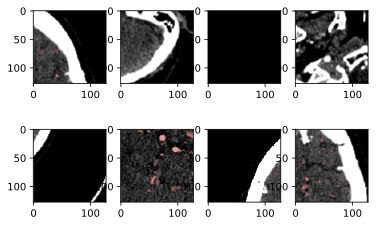

Epoch:12 step:0 loss: 0.693146
Epoch:12 step:1 loss: 0.693146
Epoch:12 step:2 loss: 0.693146
Epoch:12 step:3 loss: 0.693146
Epoch:12 step:4 loss: 0.693146
Epoch:12 step:5 loss: 0.693146
Epoch:12 step:6 loss: 0.693146
Epoch:12 step:7 loss: 0.693146
Epoch:12 step:8 loss: 0.693146
Epoch:12 step:9 loss: 0.693146
Epoch:12 step:10 loss: 0.693146
Epoch:12 step:11 loss: 0.693146
Epoch:12 step:12 loss: 0.693146
Epoch:12 step:13 loss: 0.693146
Epoch:12 step:14 loss: 0.693146
Epoch:12 step:15 loss: 0.693146
Epoch:12 step:16 loss: 0.693146
Epoch:12 step:17 loss: 0.693146
Epoch:12 step:18 loss: 0.693146
Epoch:12 step:19 loss: 0.693146
Epoch:12 step:20 loss: 0.693146
Epoch:12 step:21 loss: 0.693146
Epoch:12 step:22 loss: 0.693146
Epoch:12 step:23 loss: 0.693146
Epoch:12 step:24 loss: 0.693146
Epoch:12 step:25 loss: 0.693146
Epoch:12 step:26 loss: 0.693146
Epoch:12 step:27 loss: 0.693146
Epoch:12 step:28 loss: 0.693146
Epoch:12 step:29 loss: 0.693146
Epoch:12 step:30 loss: 0.693146
Epoch:12 step:31 l

Epoch:12 step:251 loss: 0.693146
Epoch:12 step:252 loss: 0.693146
Epoch:12 step:253 loss: 0.693146
Epoch:12 step:254 loss: 0.693146
Epoch:12 step:255 loss: 0.693146
Epoch:12 step:256 loss: 0.693146
Epoch:12 step:257 loss: 0.693146
Epoch:12 step:258 loss: 0.693146
Epoch:12 step:259 loss: 0.693146
Epoch:12 step:260 loss: 0.693146
Epoch:12 step:261 loss: 0.693146
Epoch:12 step:262 loss: 0.693146
Epoch:12 step:263 loss: 0.693146
Epoch:12 step:264 loss: 0.693146
Epoch:12 step:265 loss: 0.693146
Epoch:12 step:266 loss: 0.693146
Epoch:12 step:267 loss: 0.693146
Epoch:12 step:268 loss: 0.693146
Epoch:12 step:269 loss: 0.693146
Epoch:12 step:270 loss: 0.693146
Epoch:12 step:271 loss: 0.693146
Epoch:12 step:272 loss: 0.693146
Epoch:12 step:273 loss: 0.693146
Epoch:12 step:274 loss: 0.693146
Epoch:12 step:275 loss: 0.693146
Epoch:12 step:276 loss: 0.693146
Epoch:12 step:277 loss: 0.693146
Epoch:12 step:278 loss: 0.693146
Epoch:12 step:279 loss: 0.693146
Epoch:12 step:280 loss: 0.693146
Epoch:12 s

Epoch:12 step:499 loss: 0.693146
Epoch:12 step:500 loss: 0.693146
Epoch:12 step:501 loss: 0.693146
Epoch:12 step:502 loss: 0.693146
Epoch:12 step:503 loss: 0.693146
Epoch:12 step:504 loss: 0.693146
Epoch:12 step:505 loss: 0.693146
Epoch:12 step:506 loss: 0.693146
Epoch:12 step:507 loss: 0.693146
Epoch:12 step:508 loss: 0.693146
Epoch:12 step:509 loss: 0.693146
Epoch:12 step:510 loss: 0.693146
Epoch:12 step:511 loss: 0.693146
Epoch:12 step:512 loss: 0.693146
Epoch:12 step:513 loss: 0.693146
Epoch:12 step:514 loss: 0.693146
Epoch:12 step:515 loss: 0.693146
Epoch:12 step:516 loss: 0.693146
Epoch:12 step:517 loss: 0.693146
Epoch:12 step:518 loss: 0.693146
Epoch:12 step:519 loss: 0.693146
Epoch:12 step:520 loss: 0.693146
Epoch:12 step:521 loss: 0.693146
Epoch:12 step:522 loss: 0.693146
Epoch:12 step:523 loss: 0.693146
Epoch:12 step:524 loss: 0.693146
Epoch:12 step:525 loss: 0.693146
Epoch:12 step:526 loss: 0.693146
Epoch:12 step:527 loss: 0.693146
Epoch:12 step:528 loss: 0.693146
Epoch:12 s

Epoch:12 step:747 loss: 0.693146
Epoch:12 step:748 loss: 0.693146
Epoch:12 step:749 loss: 0.693146
Epoch:12 step:750 loss: 0.693146
Epoch:12 step:751 loss: 0.693146
Epoch:12 step:752 loss: 0.693146
Epoch:12 step:753 loss: 0.693146
Epoch:12 step:754 loss: 0.693146
Epoch:12 step:755 loss: 0.693146
Epoch:12 step:756 loss: 0.693146
Epoch:12 step:757 loss: 0.693146
Epoch:12 step:758 loss: 0.693146
Epoch:12 step:759 loss: 0.693146
Epoch:12 step:760 loss: 0.693146
Epoch:12 step:761 loss: 0.693146
Epoch:12 step:762 loss: 0.693146
Epoch:12 step:763 loss: 0.693146
Epoch:12 step:764 loss: 0.693146
Epoch:12 step:765 loss: 0.693146
Epoch:12 step:766 loss: 0.693146
Epoch:12 step:767 loss: 0.693146
Epoch:12 step:768 loss: 0.693146
Epoch:12 step:769 loss: 0.693146
Epoch:12 step:770 loss: 0.693146
Epoch:12 step:771 loss: 0.693146
Epoch:12 step:772 loss: 0.693146
Epoch:12 step:773 loss: 0.693146
Epoch:12 step:774 loss: 0.693146
Epoch:12 step:775 loss: 0.693146
Epoch:12 step:776 loss: 0.693146
Epoch:12 s

Test Epoch:12 step:85 loss: 0.693146tensor(1.6047e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:86 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:12 step:87 loss: 0.693146tensor(2.2806e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:88 loss: 0.693146tensor(6.1262e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:89 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:12 step:90 loss: 0.693146tensor(1.1015e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:91 loss: 0.693146tensor(1.3126e-09, grad_fn=<DivBackward0>)
Test Epoch:12 step:92 loss: 0.693146tensor(7.1521e-13, grad_fn=<DivBackward0>)
Test Epoch:12 step:93 loss: 0.693146tensor(2.1314e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:94 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:12 step:95 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:12 step:96 loss: 0.693146tensor(1.9665e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:97 loss: 0.693146tensor(2.2352e-13, grad_fn=<DivBackward0>)
Test 

Test Epoch:12 step:192 loss: 0.693146tensor(2.0851e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:193 loss: 0.693146tensor(2.6632e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:194 loss: 0.693146tensor(1.6863e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:195 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:12 step:196 loss: 0.693146tensor(4.1049e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:197 loss: 0.693146tensor(3.0976e-10, grad_fn=<DivBackward0>)
Test Epoch:12 step:198 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:12 step:199 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)


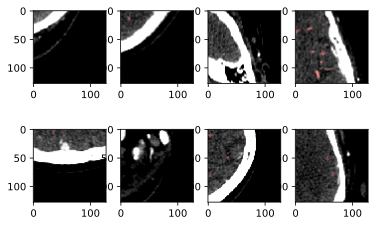

Epoch:13 step:0 loss: 0.693146
Epoch:13 step:1 loss: 0.693146
Epoch:13 step:2 loss: 0.693146
Epoch:13 step:3 loss: 0.693146
Epoch:13 step:4 loss: 0.693146
Epoch:13 step:5 loss: 0.693146
Epoch:13 step:6 loss: 0.693146
Epoch:13 step:7 loss: 0.693146
Epoch:13 step:8 loss: 0.693146
Epoch:13 step:9 loss: 0.693146
Epoch:13 step:10 loss: 0.693146
Epoch:13 step:11 loss: 0.693146
Epoch:13 step:12 loss: 0.693146
Epoch:13 step:13 loss: 0.693146
Epoch:13 step:14 loss: 0.693146
Epoch:13 step:15 loss: 0.693146
Epoch:13 step:16 loss: 0.693146
Epoch:13 step:17 loss: 0.693146
Epoch:13 step:18 loss: 0.693146
Epoch:13 step:19 loss: 0.693146
Epoch:13 step:20 loss: 0.693146
Epoch:13 step:21 loss: 0.693146
Epoch:13 step:22 loss: 0.693146
Epoch:13 step:23 loss: 0.693146
Epoch:13 step:24 loss: 0.693146
Epoch:13 step:25 loss: 0.693146
Epoch:13 step:26 loss: 0.693146
Epoch:13 step:27 loss: 0.693146
Epoch:13 step:28 loss: 0.693146
Epoch:13 step:29 loss: 0.693146
Epoch:13 step:30 loss: 0.693146
Epoch:13 step:31 l

Epoch:13 step:251 loss: 0.693146
Epoch:13 step:252 loss: 0.693146
Epoch:13 step:253 loss: 0.693146
Epoch:13 step:254 loss: 0.693146
Epoch:13 step:255 loss: 0.693146
Epoch:13 step:256 loss: 0.693146
Epoch:13 step:257 loss: 0.693146
Epoch:13 step:258 loss: 0.693146
Epoch:13 step:259 loss: 0.693146
Epoch:13 step:260 loss: 0.693146
Epoch:13 step:261 loss: 0.693146
Epoch:13 step:262 loss: 0.693146
Epoch:13 step:263 loss: 0.693146
Epoch:13 step:264 loss: 0.693146
Epoch:13 step:265 loss: 0.693146
Epoch:13 step:266 loss: 0.693146
Epoch:13 step:267 loss: 0.693146
Epoch:13 step:268 loss: 0.693146
Epoch:13 step:269 loss: 0.693146
Epoch:13 step:270 loss: 0.693146
Epoch:13 step:271 loss: 0.693146
Epoch:13 step:272 loss: 0.693146
Epoch:13 step:273 loss: 0.693146
Epoch:13 step:274 loss: 0.693146
Epoch:13 step:275 loss: 0.693146
Epoch:13 step:276 loss: 0.693146
Epoch:13 step:277 loss: 0.693146
Epoch:13 step:278 loss: 0.693146
Epoch:13 step:279 loss: 0.693146
Epoch:13 step:280 loss: 0.693146
Epoch:13 s

Epoch:13 step:499 loss: 0.693146
Epoch:13 step:500 loss: 0.693146
Epoch:13 step:501 loss: 0.693146
Epoch:13 step:502 loss: 0.693146
Epoch:13 step:503 loss: 0.693146
Epoch:13 step:504 loss: 0.693146
Epoch:13 step:505 loss: 0.693146
Epoch:13 step:506 loss: 0.693146
Epoch:13 step:507 loss: 0.693146
Epoch:13 step:508 loss: 0.693146
Epoch:13 step:509 loss: 0.693146
Epoch:13 step:510 loss: 0.693146
Epoch:13 step:511 loss: 0.693146
Epoch:13 step:512 loss: 0.693146
Epoch:13 step:513 loss: 0.693146
Epoch:13 step:514 loss: 0.693146
Epoch:13 step:515 loss: 0.693146
Epoch:13 step:516 loss: 0.693146
Epoch:13 step:517 loss: 0.693146
Epoch:13 step:518 loss: 0.693146
Epoch:13 step:519 loss: 0.693146
Epoch:13 step:520 loss: 0.693146
Epoch:13 step:521 loss: 0.693146
Epoch:13 step:522 loss: 0.693146
Epoch:13 step:523 loss: 0.693146
Epoch:13 step:524 loss: 0.693146
Epoch:13 step:525 loss: 0.693146
Epoch:13 step:526 loss: 0.693146
Epoch:13 step:527 loss: 0.693146
Epoch:13 step:528 loss: 0.693146
Epoch:13 s

Epoch:13 step:747 loss: 0.693146
Epoch:13 step:748 loss: 0.693146
Epoch:13 step:749 loss: 0.693146
Epoch:13 step:750 loss: 0.693146
Epoch:13 step:751 loss: 0.693146
Epoch:13 step:752 loss: 0.693146
Epoch:13 step:753 loss: 0.693146
Epoch:13 step:754 loss: 0.693146
Epoch:13 step:755 loss: 0.693146
Epoch:13 step:756 loss: 0.693146
Epoch:13 step:757 loss: 0.693146
Epoch:13 step:758 loss: 0.693146
Epoch:13 step:759 loss: 0.693146
Epoch:13 step:760 loss: 0.693146
Epoch:13 step:761 loss: 0.693146
Epoch:13 step:762 loss: 0.693146
Epoch:13 step:763 loss: 0.693146
Epoch:13 step:764 loss: 0.693146
Epoch:13 step:765 loss: 0.693146
Epoch:13 step:766 loss: 0.693146
Epoch:13 step:767 loss: 0.693146
Epoch:13 step:768 loss: 0.693146
Epoch:13 step:769 loss: 0.693146
Epoch:13 step:770 loss: 0.693146
Epoch:13 step:771 loss: 0.693146
Epoch:13 step:772 loss: 0.693146
Epoch:13 step:773 loss: 0.693146
Epoch:13 step:774 loss: 0.693146
Epoch:13 step:775 loss: 0.693146
Epoch:13 step:776 loss: 0.693146
Epoch:13 s

Test Epoch:13 step:85 loss: 0.693146tensor(1.1021e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:86 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:13 step:87 loss: 0.693146tensor(1.5531e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:88 loss: 0.693146tensor(4.4334e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:89 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:13 step:90 loss: 0.693146tensor(8.0054e-11, grad_fn=<DivBackward0>)
Test Epoch:13 step:91 loss: 0.693146tensor(9.0740e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:92 loss: 0.693146tensor(4.0944e-13, grad_fn=<DivBackward0>)
Test Epoch:13 step:93 loss: 0.693146tensor(1.5100e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:94 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:13 step:95 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:13 step:96 loss: 0.693146tensor(1.3441e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:97 loss: 0.693146tensor(1.5823e-13, grad_fn=<DivBackward0>)
Test 

Test Epoch:13 step:192 loss: 0.693146tensor(1.4112e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:193 loss: 0.693146tensor(1.8717e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:194 loss: 0.693146tensor(1.1640e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:195 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:13 step:196 loss: 0.693146tensor(2.9434e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:197 loss: 0.693146tensor(2.1923e-10, grad_fn=<DivBackward0>)
Test Epoch:13 step:198 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:13 step:199 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)


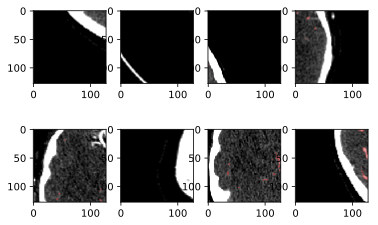

Epoch:14 step:0 loss: 0.693146
Epoch:14 step:1 loss: 0.693146
Epoch:14 step:2 loss: 0.693146
Epoch:14 step:3 loss: 0.693146
Epoch:14 step:4 loss: 0.693146
Epoch:14 step:5 loss: 0.693146
Epoch:14 step:6 loss: 0.693146
Epoch:14 step:7 loss: 0.693146
Epoch:14 step:8 loss: 0.693146
Epoch:14 step:9 loss: 0.693146
Epoch:14 step:10 loss: 0.693146
Epoch:14 step:11 loss: 0.693146
Epoch:14 step:12 loss: 0.693146
Epoch:14 step:13 loss: 0.693146
Epoch:14 step:14 loss: 0.693146
Epoch:14 step:15 loss: 0.693146
Epoch:14 step:16 loss: 0.693146
Epoch:14 step:17 loss: 0.693146
Epoch:14 step:18 loss: 0.693146
Epoch:14 step:19 loss: 0.693146
Epoch:14 step:20 loss: 0.693146
Epoch:14 step:21 loss: 0.693146
Epoch:14 step:22 loss: 0.693146
Epoch:14 step:23 loss: 0.693146
Epoch:14 step:24 loss: 0.693146
Epoch:14 step:25 loss: 0.693146
Epoch:14 step:26 loss: 0.693146
Epoch:14 step:27 loss: 0.693146
Epoch:14 step:28 loss: 0.693146
Epoch:14 step:29 loss: 0.693146
Epoch:14 step:30 loss: 0.693146
Epoch:14 step:31 l

Epoch:14 step:251 loss: 0.693146
Epoch:14 step:252 loss: 0.693146
Epoch:14 step:253 loss: 0.693146
Epoch:14 step:254 loss: 0.693146
Epoch:14 step:255 loss: 0.693146
Epoch:14 step:256 loss: 0.693146
Epoch:14 step:257 loss: 0.693146
Epoch:14 step:258 loss: 0.693146
Epoch:14 step:259 loss: 0.693146
Epoch:14 step:260 loss: 0.693146
Epoch:14 step:261 loss: 0.693146
Epoch:14 step:262 loss: 0.693146
Epoch:14 step:263 loss: 0.693146
Epoch:14 step:264 loss: 0.693146
Epoch:14 step:265 loss: 0.693146
Epoch:14 step:266 loss: 0.693146
Epoch:14 step:267 loss: 0.693146
Epoch:14 step:268 loss: 0.693146
Epoch:14 step:269 loss: 0.693146
Epoch:14 step:270 loss: 0.693146
Epoch:14 step:271 loss: 0.693146
Epoch:14 step:272 loss: 0.693146
Epoch:14 step:273 loss: 0.693146
Epoch:14 step:274 loss: 0.693146
Epoch:14 step:275 loss: 0.693146
Epoch:14 step:276 loss: 0.693146
Epoch:14 step:277 loss: 0.693146
Epoch:14 step:278 loss: 0.693146
Epoch:14 step:279 loss: 0.693146
Epoch:14 step:280 loss: 0.693146
Epoch:14 s

Epoch:14 step:499 loss: 0.693146
Epoch:14 step:500 loss: 0.693146
Epoch:14 step:501 loss: 0.693146
Epoch:14 step:502 loss: 0.693146
Epoch:14 step:503 loss: 0.693146
Epoch:14 step:504 loss: 0.693146
Epoch:14 step:505 loss: 0.693146
Epoch:14 step:506 loss: 0.693146
Epoch:14 step:507 loss: 0.693146
Epoch:14 step:508 loss: 0.693146
Epoch:14 step:509 loss: 0.693146
Epoch:14 step:510 loss: 0.693146
Epoch:14 step:511 loss: 0.693146
Epoch:14 step:512 loss: 0.693146
Epoch:14 step:513 loss: 0.693146
Epoch:14 step:514 loss: 0.693146
Epoch:14 step:515 loss: 0.693146
Epoch:14 step:516 loss: 0.693146
Epoch:14 step:517 loss: 0.693146
Epoch:14 step:518 loss: 0.693146
Epoch:14 step:519 loss: 0.693146
Epoch:14 step:520 loss: 0.693146
Epoch:14 step:521 loss: 0.693146
Epoch:14 step:522 loss: 0.693146
Epoch:14 step:523 loss: 0.693146
Epoch:14 step:524 loss: 0.693146
Epoch:14 step:525 loss: 0.693146
Epoch:14 step:526 loss: 0.693146
Epoch:14 step:527 loss: 0.693146
Epoch:14 step:528 loss: 0.693146
Epoch:14 s

Epoch:14 step:747 loss: 0.693146
Epoch:14 step:748 loss: 0.693146
Epoch:14 step:749 loss: 0.693146
Epoch:14 step:750 loss: 0.693146
Epoch:14 step:751 loss: 0.693146
Epoch:14 step:752 loss: 0.693146
Epoch:14 step:753 loss: 0.693146
Epoch:14 step:754 loss: 0.693146
Epoch:14 step:755 loss: 0.693146
Epoch:14 step:756 loss: 0.693146
Epoch:14 step:757 loss: 0.693146
Epoch:14 step:758 loss: 0.693146
Epoch:14 step:759 loss: 0.693146
Epoch:14 step:760 loss: 0.693146
Epoch:14 step:761 loss: 0.693146
Epoch:14 step:762 loss: 0.693146
Epoch:14 step:763 loss: 0.693146
Epoch:14 step:764 loss: 0.693146
Epoch:14 step:765 loss: 0.693146
Epoch:14 step:766 loss: 0.693146
Epoch:14 step:767 loss: 0.693146
Epoch:14 step:768 loss: 0.693146
Epoch:14 step:769 loss: 0.693146
Epoch:14 step:770 loss: 0.693146
Epoch:14 step:771 loss: 0.693146
Epoch:14 step:772 loss: 0.693146
Epoch:14 step:773 loss: 0.693146
Epoch:14 step:774 loss: 0.693146
Epoch:14 step:775 loss: 0.693146
Epoch:14 step:776 loss: 0.693146
Epoch:14 s

Test Epoch:14 step:85 loss: 0.693146tensor(7.3764e-11, grad_fn=<DivBackward0>)
Test Epoch:14 step:86 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:14 step:87 loss: 0.693146tensor(1.0336e-10, grad_fn=<DivBackward0>)
Test Epoch:14 step:88 loss: 0.693146tensor(3.1095e-10, grad_fn=<DivBackward0>)
Test Epoch:14 step:89 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:14 step:90 loss: 0.693146tensor(5.6001e-11, grad_fn=<DivBackward0>)
Test Epoch:14 step:91 loss: 0.693146tensor(6.0700e-10, grad_fn=<DivBackward0>)
Test Epoch:14 step:92 loss: 0.693146tensor(2.2772e-13, grad_fn=<DivBackward0>)
Test Epoch:14 step:93 loss: 0.693146tensor(1.0350e-10, grad_fn=<DivBackward0>)
Test Epoch:14 step:94 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:14 step:95 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:14 step:96 loss: 0.693146tensor(8.9206e-11, grad_fn=<DivBackward0>)
Test Epoch:14 step:97 loss: 0.693146tensor(1.0508e-13, grad_fn=<DivBackward0>)
Test 

Test Epoch:14 step:192 loss: 0.693146tensor(9.2979e-11, grad_fn=<DivBackward0>)
Test Epoch:14 step:193 loss: 0.693146tensor(1.2843e-10, grad_fn=<DivBackward0>)
Test Epoch:14 step:194 loss: 0.693146tensor(7.8049e-11, grad_fn=<DivBackward0>)
Test Epoch:14 step:195 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:14 step:196 loss: 0.693146tensor(2.0521e-10, grad_fn=<DivBackward0>)
Test Epoch:14 step:197 loss: 0.693146tensor(1.5057e-10, grad_fn=<DivBackward0>)
Test Epoch:14 step:198 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)
Test Epoch:14 step:199 loss: 0.693146tensor(0., grad_fn=<DivBackward0>)


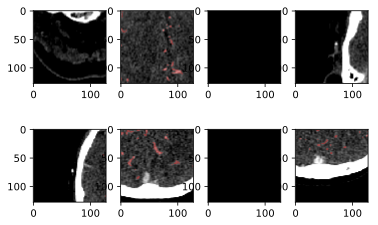

In [4]:

def iou(img_true, img_pred):
    img_true = torch.squeeze(img_true)
    img_pred = torch.squeeze(img_pred) 
    img_pred = (img_pred > 0).float()
    i = (img_true * img_pred).sum()
    u = (img_true + img_pred).sum()
    return i / u if u != 0 else uint8

if __name__ == "__main__":
    # 处理源图像与标记数据
    trainDataLoader = trainData()
    # 这个函数目的其实是为了检查一下标记和数据有没有对上
    trainDataLoader.test_show()

    im_channel = 5
    # TODO:im_size为(128,128)
    imgSize = (128,128)
    xx, yy = trainDataLoader.get_train_data(number=1000,batch_size=1,channel=im_channel,im_size=imgSize)

    # 运行unet
    model = Unet(in_ch=im_channel,out_ch=1)
    print(model)
    
    self.net.load_state_dict(torch.load('net032303_data_alter.pkl'))
    self.net.eval()
    
    # train_model(model,x,y,100,0.05)
    EPOCH = 15
    learning_rate = 0.05
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # loss_func = torch.nn.CrossEntropyLoss()
    # loss_func = torch.nn.BCELoss()
    loss_func = torch.nn.BCEWithLogitsLoss()

    accuracy = 0
    print('start train...')

    train_loss_history = []
    test_loss_history = []
    for epoch in range(EPOCH):
        step = 0

        # 取 80% 数据做训练集
        ind_test = int(len(xx)*0.8)
        for step, b_x in enumerate(xx[0:ind_test]):
            output = model(b_x)  # cnn output

            # reference: https://www.pytorchtutorial.com/pytorch-u-net/ 但不好用
            # permute such that number of desired segments would be on 4th dimension
            # TODO: 为什么专门把channel放到后面?
            # output = output.permute(0, 2, 3, 1)
            # m = output.shape[0]

            # Resizing the outputs and label to caculate pixel wise softmax loss
            # TODO: width_out = 128, height_out = 128, channel_out = 1
            # output = output.resize(m*128*128, 1)
            # label = yy[step].resize(m*128*128)

            
            loss = loss_func(torch.squeeze(output), torch.squeeze(yy[step]))
            
            # clear gradients for this training step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 1 == 0:
                pred = model(b_x)
                # print("\r" + 'Epoch: ' + str(epoch) + ' step: ' + str(step) + '[' +">>>" * int(step / 10) + ']',end=' ')
                print('Epoch:{} step:{}'.format(epoch, step),'loss: %.6f' % loss.data.numpy())
                train_loss_history.append(loss.data.numpy())
                # print('loss: %.4f' % loss.data.numpy(), '| accuracy: %.4f' % accuracy, end=' ')
                # print('loss: %.4f' % loss.data.numpy(), end=' ')
        
        # test
        for step, b_x in enumerate(xx[ind_test:]):
            output = model(b_x)  # cnn output
            # loss = loss_func(output, yy[step])
            loss = loss_func(torch.squeeze(output), torch.squeeze(yy[step]))
            
            optimizer.zero_grad()
            loss.backward()  # backpropagation, compute gradients
            optimizer.step()  # apply gradients

            if step % 1 == 0:
                print('Test Epoch:{} step:{}'.format(epoch, step), 'loss: %.6f' % loss.data.numpy(), end='')
                test_loss_history.append(loss.data.numpy())
                print(',',iou(output, yy[step]))

        _, figs = plt.subplots(2, 4)
        for i in range(2):
            for j in range(4):
                index = random.choice(range(ind_test,len(xx)))
                img_item = xx[index]
                label_item = yy[index]

                # temp = img_item.shape
                # pre_item = np.zeros(label_item.shape, dtype='float64')
                # for m in range(int(temp[0] / imgSize[0])):
                #     for n in range(int(temp[1] / imgSize[1])):
                #         pre_item[m * imgSize[0] : (m + 1) * imgSize[0], n * imgSize[1] : (n + 1) * imgSize[1]] = torch.squeeze(model(t1))

                pre_item = torch.squeeze(model(img_item))
                img_item = torch.squeeze(img_item)
                label_item = torch.squeeze(label_item)

                img_item = torch.index_select(img_item, 0, torch.tensor([2]))
                img_item = torch.squeeze(img_item)
                img_item = img_item.numpy()
                pre_item = pre_item.detach().numpy()
                label_item = label_item.numpy()
                # 标签处简单处理，显示浅红色
                img_item = img_item * 300
                img_item[img_item < 0] = 0
                img_item[img_item > 255] = 255
                img_item = img_item.astype(np.uint8)
                img_item = cv2.merge([img_item, img_item, img_item])
                img_item[(label_item > 0) & (pre_item < 1)] = img_item[(label_item > 0) & (pre_item < 1)] * 0.6 + (80, 0, 0)
                # TODO:pre_item的值在0~1之间，那么如何衡量有效值呢
                img_item[(label_item <= 0) & (pre_item >= 1)] = img_item[(label_item <= 0) & (pre_item >= 1)] * 0.6 + (0, 80, 0)
                img_item[(label_item > 0) & (pre_item >= 1)] = img_item[(label_item > 0) & (pre_item >= 1)] * 0.6 + (0, 0, 80)
                figs[i][j].imshow(img_item)
        plt.show()


In [5]:
torch.save(model.state_dict(), 'net040801_normal.pkl')